# The Nature Conservancy Fisheries Monitoring

В данном задании вам предстоит помочь The Nature Conservancy в борьбе с рыбаками-браконьерами. Необходимо по снимкам с камеры на рыболовецком судне классифицировать улов. За основу решения предлагается взять модель детектора:
github.com...tion.ipynb. Решение необходимо прислать в виде ссылки на ipython-ноутбук с указанием значения метрики на Leaderboard.

https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring

## Импорт библиотек

In [ ]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf

print(tf.__version__)

2.12.0


In [65]:
%pip install kaggle

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [66]:
import kaggle
!kaggle competitions download -c the-nature-conservancy-fisheries-monitoring

the-nature-conservancy-fisheries-monitoring.zip: Skipping, found more recently modified local copy (use --force to force download)


## Скачиваем данные

In [67]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [68]:
import kaggle
!kaggle competitions download -c the-nature-conservancy-fisheries-monitoring

the-nature-conservancy-fisheries-monitoring.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
from zipfile import ZipFile
with ZipFile('C:\Users\Asus\jupiter-neto\notebooks\the-nature-conservancy-fisheries-monitoring.zip', 'r') as zip_file:
        zip_file.extractall()


## Загружаем разметку

In [130]:
import os
import json
from glob import glob
import cv2
from pathlib import Path
ROOT = 'C:/Users/Asus/jupiter-neto/data/fish'
TRAIN_PREFIX = 'C:/Users/Asus/jupiter-neto/data/fish/train'

In [ ]:
def load_annotations():
    boxes = dict()
    for path in glob('C:/Users/Asus/jupiter-neto/data/fish/boxes/*.json'):
        # path - Это абсолютный путь к json-файлам с аннотациями
        label = os.path.basename(path).split('_', 1)[0]
        # label - будущие метки классов, берутся из сплита имен json-файлов с аннотациями
        with open(path) as src:
            # каждый json файл с аннотациями открывается как источник,
            # из его содержимого берутся значения по ключу "filename" 
            # берется имя файла,для которого дана разметка рамки, и помещается в basename
            for annotation in json.load(src):
                basename = os.path.basename(annotation['filename'])
                # Далее с помощью TRAIN_PREFIX формируется относительный путь к basename
                # и помещается всловарь annotations как значение  по ключу filename
                annotation['filename'] = os.path.join(
                    TRAIN_PREFIX, label.upper(), basename)

                for rect in annotation['annotations']:
                    rect['x'] += rect['width'] / 2
                    rect['y'] += rect['height'] / 2
                # Функция boxes.setdefault(label, []).append(annotation) добавляет значение annotation
                # в список, связанный с ключом label в словаре boxes.
                # Если ключ label уже существует в словаре boxes,
                # то значение annotation будет добавлено в список, связанный с этим ключом.
                # Если ключ label не существует,
                # то будет создан новый элемент словаря с ключом label,
                # и ему будет присвоен список, содержащий значение annotation.
                if os.path.isfile(annotation['filename']):
                    boxes.setdefault(label, []).append(annotation)
    return boxes


In [ ]:
def draw_boxes(annotation, rectangles=None, image_size=None):
    """Рисует красные и зеленые рамки вокруг объектов по данным
    аннотации и rectangles"""    
    def _draw(img, rectangles, scale_x, scale_y, color=(0, 255, 0)):
        for rect in rectangles:
            pt1 = (int((rect['x'] - rect['width'] / 2) * scale_x),
                   int((rect['y'] - rect['height'] / 2) * scale_y))
            pt2 = (int((rect['x'] + rect['width'] / 2) * scale_x),
                   int((rect['y'] + rect['height'] / 2) * scale_y))
            img = cv2.rectangle(img.copy(), pt1, pt2, 
                                color=color, thickness=4)
        return img
    
    scale_x, scale_y = 1., 1.
    
    img = cv2.imread(annotation['filename'], cv2.IMREAD_COLOR)[...,::-1]
    if image_size is not None:
        scale_x = 1. * image_size[0] / img.shape[1]
        scale_y = 1. * image_size[1] / img.shape[0]
        img = cv2.resize(img, image_size)
        
    img = _draw(img, annotation.get('annotations', []), scale_x, scale_y)
    
    if rectangles is not None:
        img = _draw(img, rectangles, 1., 1., (255, 0, 0))

    return img

### Визуализируем разметку

In [ ]:
boxes = load_annotations()  # загружаем разметку детекций

In [ ]:
import pandas as pd
# Выводим количество записей в каждом классе
# зафиксируем перечень классов, чтобы при загрузке разметки (json) нумерация классов не сбивалась)
counts = pd.DataFrame(
    [(k, len(v)) for k, v in boxes.items()],
    columns=['class', 'count']).sort_values(by='count', ascending=False).reset_index()
counts.drop(columns='index', inplace=True)
counts

,class,count
0,alb,1719
1,yft,734
2,bet,200
3,shark,176
4,dol,117
5,lag,67


In [70]:
fish_classes = counts['class'].values
fish_classes.tolist()

['alb', 'yft', 'bet', 'shark', 'dol', 'lag']

### Классы рыб с разметкой:
* 0: alb - Albacore tuna 
* 1: yft - Yellowfin tuna
* 2: bet - Bigeye tuna
* 3: shark - Sharks
* 4: dol - Dolphinfish (Mahi Mahi)
* 5: lag - Opah, Moonfish (Lamprus Guttatus)

### Классы без разметки:
* nof - No Fishes (на фото нет  рыб)
* oth - Other Fishes (на фото другие рыбы)

In [131]:
# Сколько и каких классов рыб?
fishes = os.listdir(TRAIN_PREFIX)

fishes = ['ALB', 'YFT', 'BET', 'SHARK', 'DOL', 'LAG']

In [89]:
class_weight= dict()
for class_ in fish_classes:
    weight = 1. / counts[counts['class']==class_]['count'].tolist()[0]
    class_weight[counts[counts['class']==class_].index[0]] = weight
class_weight

{0: 0.0005817335660267597,
 1: 0.0013623978201634877,
 2: 0.005,
 3: 0.005681818181818182,
 4: 0.008547008547008548,
 5: 0.014925373134328358}

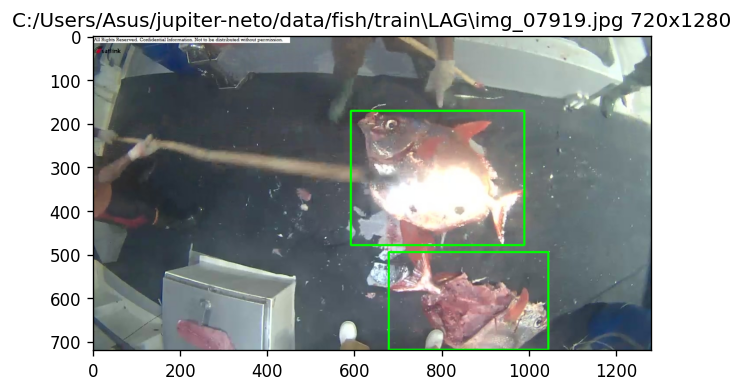

In [ ]:
from matplotlib import pyplot as plt


annotation = boxes['lag'][0]
img = draw_boxes(annotation)

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(img)
plt.title('{} {}x{}'.format(
    annotation['filename'], img.shape[0], img.shape[1]));

### Распределение размеров разметки

(array([ 229.,  980., 1287.,  876.,  384.,  169.,  102.,   22.,   20.,
          13.]),
 array([ 20.18638155,  65.96774339, 111.74910524, 157.53046708,
        203.31182893, 249.09319077, 294.87455262, 340.65591446,
        386.43727631, 432.21863815, 478.        ]),
 <BarContainer object of 10 artists>)

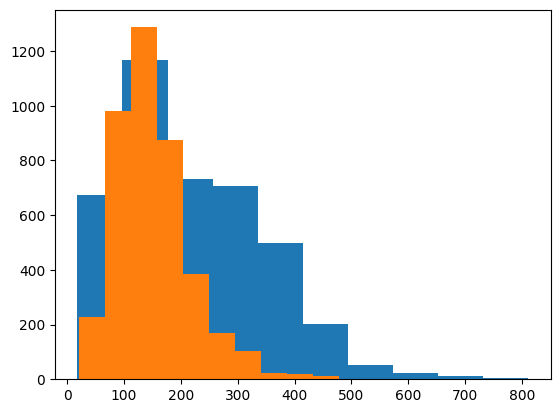

In [ ]:
# Проверяем как сильно варьируются размеры рамок. Строим гистограммы для высот и ширин рамок
annotations = sum([box['annotations']
                   for box in sum(boxes.values(), [])], [])

widths = [rect['width'] for rect in annotations]
heights = [rect['height'] for rect in annotations]

plt.hist(widths)
plt.hist(heights)

## Экстрактор признаков

In [ ]:
# from tensorflow.keras.applications import vgg16
from keras.applications import mobilenet_v2
# IMG_HEIGHT = 750
# IMG_WIDTH = 1200
IMG_HEIGHT = 224
IMG_WIDTH = 224

# features = vgg16.VGG16(weights='imagenet',
#                        include_top=False,
#                        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
features = mobilenet_v2.MobileNetV2(weights='imagenet',
                       include_top=False,
                       input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), classes=8)

# дообучаем последние 5 слоев
for layer in features.layers[:-5]:
    layer.trainable = False
# После обучения получаем признаки с последнего слоя   
feature_tensor = features.layers[-1].output
print(feature_tensor.shape)

(None, 7, 7, 1280)


## Сетка якорей (anchor grid)

In [ ]:
# сетка якорей - набор рамок фиксированного размера, каждая из которых кнтролирует свое пространство
FEATURE_SHAPE = (feature_tensor.shape[1],
                 feature_tensor.shape[2])

GRID_STEP_H = IMG_HEIGHT / FEATURE_SHAPE[0]
GRID_STEP_W = IMG_WIDTH / FEATURE_SHAPE[1]

ANCHOR_WIDTH = 150.
ANCHOR_HEIGHT = 150. 

# сетка якорей, размер определяется соотношением 
# размера входного изображения и размером тензора признаков
ANCHOR_CENTERS = np.mgrid[GRID_STEP_H/2:IMG_HEIGHT:GRID_STEP_H,
                          GRID_STEP_W/2:IMG_WIDTH:GRID_STEP_W]

In [ ]:
from scipy.special import softmax

def iou(rect, x_scale, y_scale, anchor_x, anchor_y,
        anchor_w=ANCHOR_WIDTH, anchor_h=ANCHOR_HEIGHT):
    """ Точность детекции (положение и размер рамок) = 
    предсказанная область/область разметки) """    
    rect_x1 = (rect['x'] - rect['width'] / 2) * x_scale
    rect_x2 = (rect['x'] + rect['width'] / 2) * x_scale
    
    rect_y1 = (rect['y'] - rect['height'] / 2) * y_scale
    rect_y2 = (rect['y'] + rect['height'] / 2) * y_scale
    
    anch_x1, anch_x2 = anchor_x - anchor_w / 2, anchor_x + anchor_w / 2
    anch_y1, anch_y2 = anchor_y - anchor_h / 2, anchor_y + anchor_h / 2
    
    dx = (min(rect_x2, anch_x2) - max(rect_x1, anch_x1))
    dy = (min(rect_y2, anch_y2) - max(rect_y1, anch_y1))
    
    intersection = dx * dy if (dx > 0 and dy > 0) else 0.
    
    anch_square = (anch_x2 - anch_x1) * (anch_y2 - anch_y1)
    rect_square = (rect_x2 - rect_x1) * (rect_y2 - rect_y1)
    union = anch_square + rect_square - intersection
    
    return intersection / union


def encode_anchors(annotation, img_shape, iou_thr=0.5):
    """Ф-я для кодирования якорных рамок - теперь не только
    отвечает за попадание в рамку объекта, но и оценивает принадлежности к классам"""
    encoded = np.zeros(shape=(FEATURE_SHAPE[0],
                              FEATURE_SHAPE[1], 11), dtype=np.float32)
    x_scale = 1. * IMG_WIDTH / img_shape[1]
    y_scale = 1. * IMG_HEIGHT / img_shape[0]

    for rect in annotation['annotations']:
        scores = []
        # Т.к у нас многоклассовая классификация, нужно добавить метку класса
        label = fish_classes == rect['class']
                
        for row in range(FEATURE_SHAPE[0]):
            for col in range(FEATURE_SHAPE[1]):
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                score = iou(rect, x_scale, y_scale, anchor_x, anchor_y)
                scores.append((score, anchor_x, anchor_y, row, col))
        
        scores = sorted(scores, reverse=True)
        if scores[0][0] < iou_thr:
            scores = [scores[0]]  # default anchor
        else:
            scores = [e for e in scores if e[0] > iou_thr]
            
        for score, anchor_x, anchor_y, row, col in scores:
            dx = (anchor_x - rect['x'] * x_scale) / ANCHOR_WIDTH
            dy = (anchor_y - rect['y'] * y_scale) / ANCHOR_HEIGHT
            dw = (ANCHOR_WIDTH - rect['width'] * x_scale) / ANCHOR_WIDTH
            dh = (ANCHOR_HEIGHT - rect['height'] * y_scale) / ANCHOR_HEIGHT
            # Добавили логиты для меток классов
            encoded[row, col] = np.array([*label, 1., dx, dy, dw, dh])

    return encoded

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def decode_prediction(prediction, conf_thr=0.1):
    rectangles = []
    for row in range(FEATURE_SHAPE[0]):
        for col in range(FEATURE_SHAPE[1]):

            # заполняем предсказанные вероятности каждого из 6-и классов в поля 'label'                    
            label = np.empty(6)
            # достаем из предсказания значения логитов для разных классов, conf, dx, dy, dw, dh 
            label[0], label[1], label[2], label[3], label[4], label[5], conf, dx, dy, dw, dh = prediction[row, col]
            conf = _sigmoid(conf)
            # Метка класса  определяется с помощью софтмакса
            label = softmax(label)

            if conf > conf_thr:
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                # рамки теперь отвечают и за то, какой класс туда попал
                rectangles.append({'x': anchor_x - dx * ANCHOR_WIDTH,
                                   'y': anchor_y - dy * ANCHOR_HEIGHT,
                                   'width': ANCHOR_WIDTH - dw * ANCHOR_WIDTH,
                                   'height': ANCHOR_HEIGHT - dh * ANCHOR_HEIGHT,
                                   'conf': conf,
                                   'label': np.argmax(_sigmoid(label)),
                                   'labels': label})
    return rectangles

def non_max_suppression(rectangles, max_output_size, iou_threshold=0.5):
    """NMS - Non maximum suppression -один и тот же объект может быть обведен
    в несколько пересекающихся рамок, то для каждой рамки считается IOU.
    Если она больше порогового значения - обе рамки относятся к одному объекту.
    Берем ту рамку, у которой вероятность принадлежности к классу максимальная,
    остальные убираем"""
    if not rectangles:
        return rectangles
    
    boxes = [[r['y'],
              r['x'],
              r['y'] + r['height'],
              r['x'] + r['width']] for r in rectangles]
    scores = [r['conf'] for r in rectangles]
    indices = tf.image.non_max_suppression(np.array(boxes),
                                           np.array(scores),
                                           max_output_size,
                                           iou_threshold)
    
    return [rectangles[i] for i in indices]

## Валидация энкодинга/декодинга якорей

Text(0.5, 1.0, 'C:/Users/Asus/jupiter-neto/data/fish/train\\LAG\\img_07919.jpg 224x224')

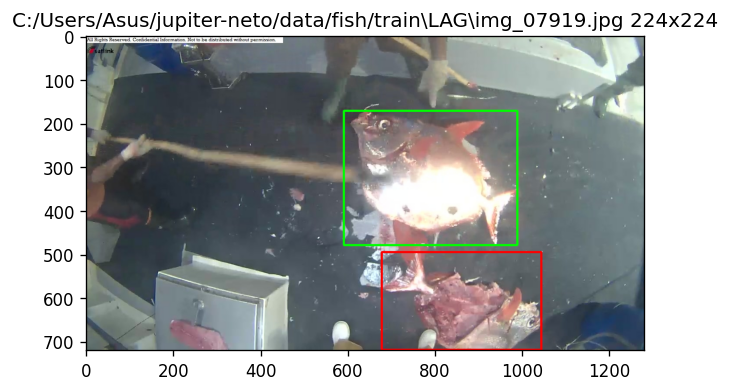

In [ ]:
annotation = boxes['lag'][0]

encoded = encode_anchors(annotation,
                         img_shape=(IMG_HEIGHT, IMG_WIDTH),
                         iou_thr=0.1)

decoded = decode_prediction(encoded, conf_thr=0.7)
decoded = sorted(decoded, key = lambda e: -e['conf'])

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(draw_boxes(annotation, decoded))
plt.title('{} {}x{}'.format(
    annotation['filename'], img.shape[0], img.shape[1]))

## Функция потерь

In [97]:
K = tf.keras.backend

def confidence_loss(y_true, y_pred):
    conf_loss = K.binary_crossentropy(y_true[..., 6], 
                                      y_pred[..., 6],
                                      from_logits=True)
    return conf_loss

def smooth_l1(y_true, y_pred):
    abs_loss = K.abs(y_true[..., -4:] - y_pred[..., -4:])
    square_loss = 0.5 * K.square(y_true[..., -4:] - y_pred[..., -4:])
    mask = K.cast(K.greater(abs_loss, 1.), 'float32')
    total_loss = (abs_loss - 0.5) * mask + 0.5 * square_loss * (1. - mask)
    return K.sum(total_loss, axis=-1)

def classification_loss(y_tr, y_pr, alpha=0.25, gamma=2.0):
  
    y_true = y_tr[..., :6]
    y_pred = y_pr[..., :6]

    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
        labels=y_true, logits=y_pred)
    
    probs = tf.nn.softmax(y_pred)
    alpha = tf.where(tf.equal(y_true, 1.0), alpha, (1.0 - alpha))
    pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
    loss = alpha * tf.pow(1.0 - pt, gamma) * cross_entropy
    
    return tf.reduce_sum(loss, axis=-1)


def total_loss(y_true, y_pred, neg_pos_ratio=3):
    batch_size = K.shape(y_true)[0]
    
    y_true = K.reshape(y_true, (batch_size, -1, 11))
    y_pred = K.reshape(y_pred, (batch_size, -1, 11))
    
    # TODO: добавьте функцию потерь для классификации детекции
    cls_loss = classification_loss(y_true, y_pred)
  
    # confidence loss
    conf_loss = confidence_loss(y_true, y_pred)
    
    # smooth l1 loss
    loc_loss = smooth_l1(y_true, y_pred)
    
    # positive examples loss
    pos_conf_loss = K.sum(conf_loss * y_true[..., 6], axis=-1)
    pos_class_loss = K.sum(cls_loss * y_true[..., 6], axis=-1)
    pos_loc_loss = K.sum(loc_loss * y_true[..., 6], axis=-1)
   
    # negative examples loss
    anchors = K.shape(y_true)[1]
    num_pos = K.sum(y_true[..., 6], axis=-1)
    num_pos_avg = K.mean(num_pos)
    num_neg = K.min([neg_pos_ratio * (num_pos_avg) + 1., K.cast(anchors, 'float32')])
    
    # hard negative mining
    neg_conf_loss, _ = tf.nn.top_k(conf_loss * (1. - y_true[..., 6]),
                                   k=K.cast(num_neg, 'int32'))

    neg_conf_loss = K.sum(neg_conf_loss, axis=-1)
    
    # total conf loss
    total_conf_loss = (neg_conf_loss + pos_conf_loss) / (num_neg + num_pos + 1e-32)
    cls_loss = pos_class_loss / (num_pos + 1e-32)
    loc_loss = pos_loc_loss / (num_pos + 1e-32)
    
    return total_conf_loss + 0.5 * loc_loss + cls_loss

## Загрузка данных

In [98]:
from random import shuffle

def load_img(path, target_size=(IMG_WIDTH, IMG_HEIGHT)):
    img = cv2.imread(path, cv2.IMREAD_COLOR)[...,::-1]
    img_shape = img.shape
    img_resized = cv2.resize(img, target_size)
    # return img_shape, vgg16.preprocess_input(img_resized.astype(np.float32))
    return img_shape, mobilenet_v2.preprocess_input(img_resized.astype(np.float32))

def data_generator(boxes, batch_size=32):
    boxes = sum(boxes.values(), [])
    while True:
        shuffle(boxes)
        for i in range(len(boxes)//batch_size):
            X, y = [], []
            for j in range(i*batch_size,(i+1)*batch_size):
                img_shape, img = load_img(boxes[j]['filename'])
                # TODO: добавьте one-hot encoding в разметку для классов
                y_ = encode_anchors(boxes[j], img_shape)
                y.append(y_)
                X.append(img)
            yield np.array(X), np.array(y)

## Добавляем выход детектора

In [99]:
output = tf.keras.layers.BatchNormalization()(feature_tensor)

# TODO: добавьте выходы для классификации детекции
# Добавлено 6 выходов для классификации детекции 6-и классов (alb, bet, dol, lag, shark, yft).
# Вероятности классов 'Other Fishes' и 'No Fishes' возьмем из примера (sample_submission), они будут константами (не входят в выходы НС):
#  Oth: 0.079142
#  NoF: 0.123081

# Итого получилось 11 выходов: 
# - 6 классов (вероятности каждого из классов, рассчитанные по функции sоftmax)
# - 2 координаты x,y верхнего левого угла распознанного изображения
# - 2 величины смещения (высота, ширина) от координат верхнего левого угла распознанного изображения
# - 1 вероятность наличия распознанного изображения на картинке (по функции сигмоиды)
output = tf.keras.layers.Conv2D(11,
                                kernel_size=(1, 1), 
                                activation='linear',
                                kernel_regularizer='l2')(output)
model = tf.keras.models.Model(inputs=features.inputs, outputs=output)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

                                                                                                  
 block_2_expand (Conv2D)        (None, 56, 56, 144)  3456        ['block_1_project_BN[0][0]']     
                                                                                                  
 block_2_expand_BN (BatchNormal  (None, 56, 56, 144)  576        ['block_2_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_2_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_2_expand_BN[0][0]']      
                                                                                                  
 block_2_depthwise (DepthwiseCo  (None, 56, 56, 144)  1296       ['block_2_expand_relu[0][0]']    
 nv2D)                                                                                            
          

## Обучение

In [100]:
adam = tf.keras.optimizers.legacy.Adam(learning_rate=3e-4, decay=1e-6)
model.compile(optimizer=adam, 
              loss=total_loss,
              metrics=[confidence_loss, classification_loss, smooth_l1])

In [101]:
batch_size = 32

gen = data_generator(boxes, batch_size=batch_size)
steps_per_epoch = sum(map(len, boxes.values()), 0) / batch_size

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'fishdetector.hdf5',
    monitor='loss',
    verbose=1,  
    save_best_only=True, 
    save_weights_only=False,
    mode='auto',
    save_freq=10)

model.fit(gen, 
          steps_per_epoch=steps_per_epoch,
          epochs=10,
          callbacks=[checkpoint])

Epoch 1/10
 9/94 [=>............................] - ETA: 1:27 - loss: 1.4710 - confidence_loss: 0.7894 - classification_loss: 0.4129 - smooth_l1: 1.7551
Epoch 1: loss improved from inf to 1.44758, saving model to fishdetector.hdf5
19/94 [=====>........................] - ETA: 1:15 - loss: 1.3125 - confidence_loss: 0.7454 - classification_loss: 0.4857 - smooth_l1: 1.8373
Epoch 1: loss improved from 1.44758 to 1.30044, saving model to fishdetector.hdf5
29/94 [========>.....................] - ETA: 1:07 - loss: 1.2276 - confidence_loss: 0.7003 - classification_loss: 0.5449 - smooth_l1: 1.7230
Epoch 1: loss improved from 1.30044 to 1.21791, saving model to fishdetector.hdf5
39/94 [===========>..................] - ETA: 59s - loss: 1.1567 - confidence_loss: 0.6651 - classification_loss: 0.5855 - smooth_l1: 1.7027 
Epoch 1: loss improved from 1.21791 to 1.15220, saving model to fishdetector.hdf5
49/94 [==============>...............] - ETA: 49s - loss: 1.1071 - confidence_loss: 0.6356 - clas

In [102]:
model.fit(gen, 
          steps_per_epoch=steps_per_epoch,
          initial_epoch=10,
          epochs=20,
          callbacks=[checkpoint])

Epoch 11/20
 9/94 [=>............................] - ETA: 1:36 - loss: 0.4441 - confidence_loss: 0.1362 - classification_loss: 0.3843 - smooth_l1: 1.2398
Epoch 11: loss improved from 0.46871 to 0.44064, saving model to fishdetector.hdf5
19/94 [=====>........................] - ETA: 1:26 - loss: 0.4368 - confidence_loss: 0.1340 - classification_loss: 0.3811 - smooth_l1: 1.2361
Epoch 11: loss improved from 0.44064 to 0.43747, saving model to fishdetector.hdf5
29/94 [========>.....................] - ETA: 1:14 - loss: 0.4370 - confidence_loss: 0.1324 - classification_loss: 0.3810 - smooth_l1: 1.2414
Epoch 11: loss improved from 0.43747 to 0.43607, saving model to fishdetector.hdf5
39/94 [===========>..................] - ETA: 1:01 - loss: 0.4352 - confidence_loss: 0.1307 - classification_loss: 0.3800 - smooth_l1: 1.2516
Epoch 11: loss improved from 0.43607 to 0.43468, saving model to fishdetector.hdf5
49/94 [==============>...............] - ETA: 50s - loss: 0.4352 - confidence_loss: 0.12

In [103]:
model.fit(gen, 
          steps_per_epoch=steps_per_epoch,
          initial_epoch=20,
          epochs=30,
          callbacks=[checkpoint])

Epoch 21/30
 9/94 [=>............................] - ETA: 1:32 - loss: 0.1526 - confidence_loss: 0.0200 - classification_loss: 0.2423 - smooth_l1: 0.9751
Epoch 21: loss improved from 0.16385 to 0.15118, saving model to fishdetector.hdf5
19/94 [=====>........................] - ETA: 1:20 - loss: 0.1456 - confidence_loss: 0.0184 - classification_loss: 0.2426 - smooth_l1: 0.9663
Epoch 21: loss improved from 0.15118 to 0.14455, saving model to fishdetector.hdf5
29/94 [========>.....................] - ETA: 1:08 - loss: 0.1528 - confidence_loss: 0.0191 - classification_loss: 0.2425 - smooth_l1: 0.9621
Epoch 21: loss did not improve from 0.14455
39/94 [===========>..................] - ETA: 57s - loss: 0.1547 - confidence_loss: 0.0191 - classification_loss: 0.2422 - smooth_l1: 0.9700
Epoch 21: loss did not improve from 0.14455
49/94 [==============>...............] - ETA: 46s - loss: 0.1520 - confidence_loss: 0.0187 - classification_loss: 0.2424 - smooth_l1: 0.9694
Epoch 21: loss did not imp

In [122]:
model.fit(gen, 
          steps_per_epoch=steps_per_epoch,
          initial_epoch=30,
          epochs=50,
          callbacks=[checkpoint])

Epoch 31/50
 9/94 [=>............................] - ETA: 3:25 - loss: 0.0727 - confidence_loss: 0.0061 - classification_loss: 0.1949 - smooth_l1: 0.8034
Epoch 31: loss improved from 0.08294 to 0.07200, saving model to fishdetector.hdf5
19/94 [=====>........................] - ETA: 2:59 - loss: 0.0734 - confidence_loss: 0.0061 - classification_loss: 0.1953 - smooth_l1: 0.8051
Epoch 31: loss did not improve from 0.07200
29/94 [========>.....................] - ETA: 2:32 - loss: 0.0738 - confidence_loss: 0.0061 - classification_loss: 0.1967 - smooth_l1: 0.8156
Epoch 31: loss did not improve from 0.07200
39/94 [===========>..................] - ETA: 2:06 - loss: 0.0758 - confidence_loss: 0.0063 - classification_loss: 0.1965 - smooth_l1: 0.8168
Epoch 31: loss did not improve from 0.07200
49/94 [==============>...............] - ETA: 1:42 - loss: 0.0775 - confidence_loss: 0.0066 - classification_loss: 0.1966 - smooth_l1: 0.8173
Epoch 31: loss did not improve from 0.07200
59/94 [============

In [ ]:
model.fit(gen, 
          steps_per_epoch=steps_per_epoch,
          initial_epoch=50,
          epochs=100,
          callbacks=[checkpoint])

## Результат работы детектора

In [132]:
model.load_weights('C:/Users/Asus/jupiter-neto/notebooks/fishdetector.hdf5')

1/1 [==============================] - 1s 1s/step


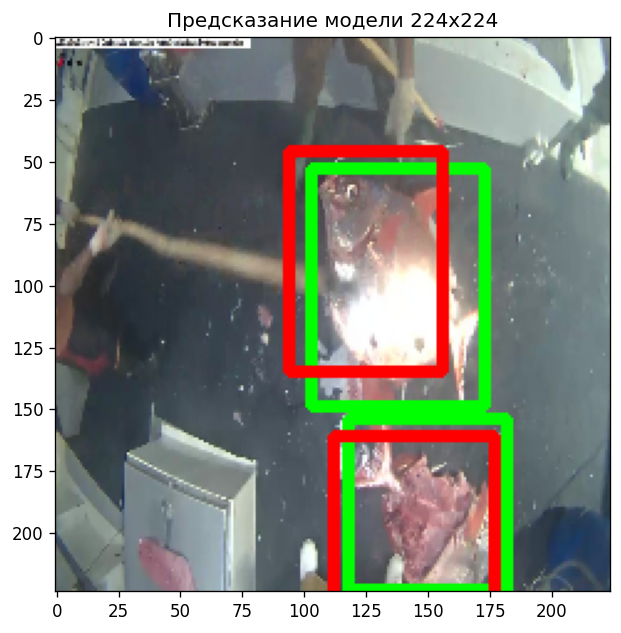

In [133]:
annotation = boxes['lag'][0]

_, sample_img = load_img(annotation['filename'])
pred = model.predict(np.array([sample_img,]))

decoded = decode_prediction(pred[0], conf_thr=0.2)
decoded = non_max_suppression(decoded,
                              max_output_size=5,
                              iou_threshold=0.1)

plt.figure(figsize=(6, 6), dpi=120)
img = draw_boxes(annotation, decoded, (IMG_WIDTH, IMG_HEIGHT))
plt.imshow(img)
plt.title('Предсказание модели {}x{}'.format(*img.shape));

## Визуализируем предсказание на тесте

1/1 [==============================] - 1s 1s/step


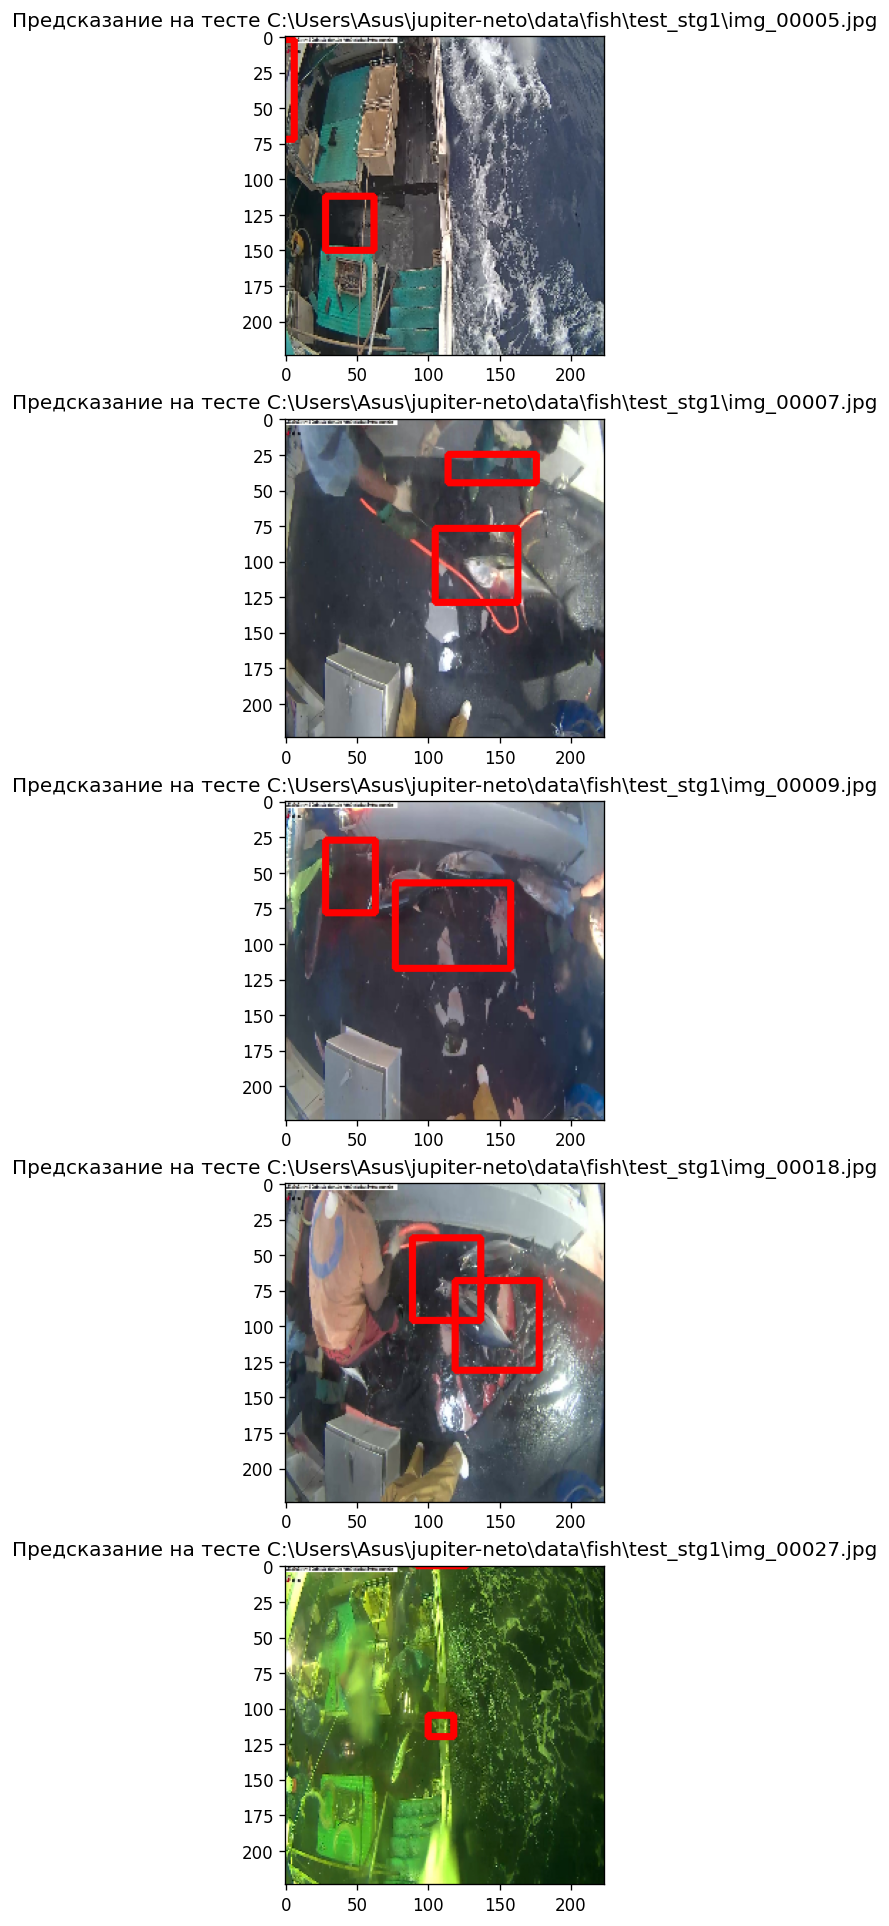

In [135]:

test_images = glob(str(Path(ROOT,'test_stg1/*.jpg')))[:5]

plt.figure(figsize=(6, 4 * len(test_images)), dpi=120)

for i, filename in enumerate(test_images):
    _, sample_img = load_img(filename)
    pred = model.predict(np.array([sample_img,]))

    decoded = decode_prediction(pred[0], conf_thr=0.0)
    decoded = non_max_suppression(decoded,
                                  max_output_size=2,
                                  iou_threshold=0.1)
    
    plt.subplot(len(test_images), 1, i + 1)
    img = draw_boxes({'filename': filename}, decoded, (IMG_WIDTH, IMG_HEIGHT))
    plt.imshow(img)
    plt.title('Предсказание на тесте {}'.format(filename));
plt.show()

## Агрегация результатов

In [136]:
from tqdm import tqdm
def make_predictions(filepath, prefix):
    ptable = pd.DataFrame(columns=['image', 'ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK','YFT'])
    all_files = glob(filepath)
    for i, file in enumerate(tqdm(all_files)):
        bn = os.path.basename(file)
        bn = prefix + bn
        _, sample_img = load_img(file)
        
        pred = model.predict(np.array([sample_img,]))[0]
        decoded = decode_prediction(pred, conf_thr=0.01)
        decoded = non_max_suppression(decoded,
                              max_output_size=1,
                              iou_threshold=0.5)
        if len(decoded)>0:
            decoded = decoded[0]['labels']

            ptable.loc[i, 'image'] = bn
            ptable.loc[i, 'ALB'] = decoded[0]
            ptable.loc[i, 'BET'] = decoded[2]
            ptable.loc[i, 'DOL'] = decoded[4]
            ptable.loc[i, 'LAG'] = decoded[5]
            ptable.loc[i, 'SHARK'] = decoded[3]
            ptable.loc[i, 'YFT'] = decoded[1]
            ptable.loc[i, 'NoF'] = 0.123081 # фиксированная вероятность для класса 'No Fishes' из файла sample_submission
            ptable.loc[i, 'OTHER'] = 0.079142 # фиксированная вероятность для класса 'Other Fishes' из файла sample_submission
        else:
            ptable.loc[i, 'image'] = bn
            ptable.loc[i, 'ALB'] = 0.0
            ptable.loc[i, 'BET'] = 0.0
            ptable.loc[i, 'DOL'] = 0.0
            ptable.loc[i, 'LAG'] = 0.0
            ptable.loc[i, 'SHARK'] = 0.0
            ptable.loc[i, 'YFT'] = 0.0
            ptable.loc[i, 'NoF'] = 0.123081
    return ptable

In [138]:
ptable_1 = make_predictions(str(Path(ROOT,'test_stg1/*.jpg')), '')
print(ptable_1.shape)
ptable_1.to_csv(Path(ROOT,"submit1.csv"), index=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step


  0%|          | 1/1000 [00:01<24:43,  1.48s/it]

1/1 [==============================] - 1s 1s/step


  0%|          | 2/1000 [00:02<24:07,  1.45s/it]

1/1 [==============================] - 1s 1s/step


  0%|          | 3/1000 [00:04<24:12,  1.46s/it]

1/1 [==============================] - 1s 1s/step


  0%|          | 4/1000 [00:05<25:06,  1.51s/it]

1/1 [==============================] - 1s 1s/step


  0%|          | 5/1000 [00:07<24:55,  1.50s/it]

1/1 [==============================] - 1s 1s/step


  1%|          | 6/1000 [00:08<24:16,  1.47s/it]

1/1 [==============================] - 1s 1s/step


  1%|          | 7/1000 [00:10<24:42,  1.49s/it]

1/1 [==============================] - 1s 1s/step


  1%|          | 8/1000 [00:11<24:57,  1.51s/it]

1/1 [==============================] - 1s 1s/step


  1%|          | 9/1000 [00:13<24:38,  1.49s/it]

1/1 [==============================] - 1s 1s/step


  1%|          | 10/1000 [00:14<23:53,  1.45s/it]

1/1 [==============================] - 1s 1s/step


  1%|          | 11/1000 [00:16<23:30,  1.43s/it]

1/1 [==============================] - 1s 1s/step


  1%|          | 12/1000 [00:17<23:09,  1.41s/it]

1/1 [==============================] - 1s 1s/step


  1%|▏         | 13/1000 [00:18<22:22,  1.36s/it]

1/1 [==============================] - 1s 1s/step


  1%|▏         | 14/1000 [00:20<22:08,  1.35s/it]

1/1 [==============================] - 1s 1s/step


  2%|▏         | 15/1000 [00:21<22:24,  1.37s/it]

1/1 [==============================] - 1s 1s/step


  2%|▏         | 16/1000 [00:22<22:52,  1.39s/it]

1/1 [==============================] - 1s 1s/step


  2%|▏         | 17/1000 [00:24<22:20,  1.36s/it]

1/1 [==============================] - 1s 1s/step


  2%|▏         | 18/1000 [00:25<22:19,  1.36s/it]

1/1 [==============================] - 1s 1s/step


  2%|▏         | 19/1000 [00:26<22:32,  1.38s/it]

1/1 [==============================] - 1s 1s/step


  2%|▏         | 20/1000 [00:28<22:48,  1.40s/it]

1/1 [==============================] - 1s 1s/step


  2%|▏         | 21/1000 [00:29<23:34,  1.44s/it]

1/1 [==============================] - 1s 1s/step


  2%|▏         | 22/1000 [00:31<23:59,  1.47s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 23/1000 [00:33<25:32,  1.57s/it]

1/1 [==============================] - 1s 1s/step


  2%|▏         | 24/1000 [00:34<25:39,  1.58s/it]

1/1 [==============================] - 1s 1s/step


  2%|▎         | 25/1000 [00:36<25:42,  1.58s/it]

1/1 [==============================] - 1s 1s/step


  3%|▎         | 26/1000 [00:38<25:32,  1.57s/it]

1/1 [==============================] - 1s 1s/step


  3%|▎         | 27/1000 [00:39<25:12,  1.55s/it]

1/1 [==============================] - 1s 1s/step


  3%|▎         | 28/1000 [00:40<24:28,  1.51s/it]

1/1 [==============================] - 1s 1s/step


  3%|▎         | 29/1000 [00:42<23:42,  1.46s/it]

1/1 [==============================] - 1s 1s/step


  3%|▎         | 30/1000 [00:43<23:49,  1.47s/it]

1/1 [==============================] - 1s 1s/step


  3%|▎         | 31/1000 [00:45<23:37,  1.46s/it]

1/1 [==============================] - 1s 1s/step


  3%|▎         | 32/1000 [00:46<23:25,  1.45s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 33/1000 [00:48<24:39,  1.53s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 34/1000 [00:50<26:09,  1.62s/it]

1/1 [==============================] - 1s 1s/step


  4%|▎         | 35/1000 [00:51<25:25,  1.58s/it]

1/1 [==============================] - 2s 2s/step


  4%|▎         | 36/1000 [00:53<26:44,  1.66s/it]

1/1 [==============================] - 2s 2s/step


  4%|▎         | 37/1000 [00:55<26:41,  1.66s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 38/1000 [00:56<27:01,  1.69s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 39/1000 [00:59<29:08,  1.82s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 40/1000 [01:01<30:07,  1.88s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 41/1000 [01:02<29:04,  1.82s/it]

1/1 [==============================] - 1s 1s/step


  4%|▍         | 42/1000 [01:04<27:43,  1.74s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 43/1000 [01:06<27:23,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 44/1000 [01:07<28:18,  1.78s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 45/1000 [01:09<28:42,  1.80s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 46/1000 [01:11<28:26,  1.79s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 47/1000 [01:13<29:15,  1.84s/it]

1/1 [==============================] - 1s 1s/step


  5%|▍         | 48/1000 [01:15<28:00,  1.77s/it]

1/1 [==============================] - 1s 1s/step


  5%|▍         | 49/1000 [01:16<26:11,  1.65s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 50/1000 [01:18<27:50,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 51/1000 [01:20<27:20,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 52/1000 [01:21<27:01,  1.71s/it]

1/1 [==============================] - 1s 1s/step


  5%|▌         | 53/1000 [01:23<25:03,  1.59s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 54/1000 [01:24<25:38,  1.63s/it]

1/1 [==============================] - 1s 1s/step


  6%|▌         | 55/1000 [01:26<25:15,  1.60s/it]

1/1 [==============================] - 1s 1s/step


  6%|▌         | 56/1000 [01:27<24:11,  1.54s/it]

1/1 [==============================] - 1s 1s/step


  6%|▌         | 57/1000 [01:29<24:17,  1.55s/it]

1/1 [==============================] - 1s 1s/step


  6%|▌         | 58/1000 [01:31<24:42,  1.57s/it]

1/1 [==============================] - 1s 1s/step


  6%|▌         | 59/1000 [01:32<24:41,  1.57s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 60/1000 [01:34<25:33,  1.63s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 61/1000 [01:36<29:22,  1.88s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 62/1000 [01:38<28:14,  1.81s/it]

1/1 [==============================] - 1s 1s/step


  6%|▋         | 63/1000 [01:39<26:48,  1.72s/it]

1/1 [==============================] - 2s 2s/step


  6%|▋         | 64/1000 [01:41<27:38,  1.77s/it]

1/1 [==============================] - 1s 1s/step


  6%|▋         | 65/1000 [01:43<26:22,  1.69s/it]

1/1 [==============================] - 1s 1s/step


  7%|▋         | 66/1000 [01:44<25:03,  1.61s/it]

1/1 [==============================] - 1s 1s/step


  7%|▋         | 67/1000 [01:46<24:04,  1.55s/it]

1/1 [==============================] - 1s 1s/step


  7%|▋         | 68/1000 [01:47<24:05,  1.55s/it]

1/1 [==============================] - 1s 1s/step


  7%|▋         | 69/1000 [01:49<23:19,  1.50s/it]

1/1 [==============================] - 1s 1s/step


  7%|▋         | 70/1000 [01:50<22:08,  1.43s/it]

1/1 [==============================] - 1s 1s/step


  7%|▋         | 71/1000 [01:51<21:06,  1.36s/it]

1/1 [==============================] - 1s 1s/step


  7%|▋         | 72/1000 [01:52<21:14,  1.37s/it]

1/1 [==============================] - 1s 1s/step


  7%|▋         | 73/1000 [01:54<21:24,  1.39s/it]

1/1 [==============================] - 1s 1s/step


  7%|▋         | 74/1000 [01:55<20:46,  1.35s/it]

1/1 [==============================] - 1s 1s/step


  8%|▊         | 75/1000 [01:57<20:57,  1.36s/it]

1/1 [==============================] - 1s 1s/step


  8%|▊         | 76/1000 [01:58<20:55,  1.36s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 77/1000 [02:00<22:25,  1.46s/it]

1/1 [==============================] - 1s 1s/step


  8%|▊         | 78/1000 [02:01<22:19,  1.45s/it]

1/1 [==============================] - 1s 1s/step


  8%|▊         | 79/1000 [02:02<22:17,  1.45s/it]

1/1 [==============================] - 1s 1s/step


  8%|▊         | 80/1000 [02:04<22:30,  1.47s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 81/1000 [02:06<24:49,  1.62s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 82/1000 [02:08<25:02,  1.64s/it]

1/1 [==============================] - 1s 1s/step


  8%|▊         | 83/1000 [02:09<24:16,  1.59s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 84/1000 [02:11<25:15,  1.65s/it]

1/1 [==============================] - 1s 1s/step


  8%|▊         | 85/1000 [02:12<24:06,  1.58s/it]

1/1 [==============================] - 1s 1s/step


  9%|▊         | 86/1000 [02:14<23:52,  1.57s/it]

1/1 [==============================] - 2s 2s/step


  9%|▊         | 87/1000 [02:16<24:34,  1.61s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 88/1000 [02:17<25:24,  1.67s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 89/1000 [02:19<25:24,  1.67s/it]

1/1 [==============================] - 1s 1s/step


  9%|▉         | 90/1000 [02:21<24:41,  1.63s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 91/1000 [02:22<25:05,  1.66s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 92/1000 [02:24<24:57,  1.65s/it]

1/1 [==============================] - 1s 1s/step


  9%|▉         | 93/1000 [02:26<24:37,  1.63s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 94/1000 [02:27<25:24,  1.68s/it]

1/1 [==============================] - 1s 1s/step


 10%|▉         | 95/1000 [02:29<24:49,  1.65s/it]

1/1 [==============================] - 1s 1s/step


 10%|▉         | 96/1000 [02:30<24:29,  1.63s/it]

1/1 [==============================] - 1s 1s/step


 10%|▉         | 97/1000 [02:32<22:57,  1.53s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 98/1000 [02:34<24:10,  1.61s/it]

1/1 [==============================] - 1s 1s/step


 10%|▉         | 99/1000 [02:35<23:07,  1.54s/it]

1/1 [==============================] - 1s 1s/step


 10%|█         | 100/1000 [02:36<22:46,  1.52s/it]

1/1 [==============================] - 1s 1s/step


 10%|█         | 101/1000 [02:38<22:35,  1.51s/it]

1/1 [==============================] - 1s 1s/step


 10%|█         | 102/1000 [02:39<22:09,  1.48s/it]

1/1 [==============================] - 1s 1s/step


 10%|█         | 103/1000 [02:41<21:27,  1.44s/it]

1/1 [==============================] - 1s 1s/step


 10%|█         | 104/1000 [02:42<20:54,  1.40s/it]

1/1 [==============================] - 1s 1s/step


 10%|█         | 105/1000 [02:43<20:04,  1.35s/it]

1/1 [==============================] - 1s 1s/step


 11%|█         | 106/1000 [02:45<20:27,  1.37s/it]

1/1 [==============================] - 1s 1s/step


 11%|█         | 107/1000 [02:46<21:06,  1.42s/it]

1/1 [==============================] - 1s 1s/step


 11%|█         | 108/1000 [02:48<21:13,  1.43s/it]

1/1 [==============================] - 1s 1s/step


 11%|█         | 109/1000 [02:49<21:38,  1.46s/it]

1/1 [==============================] - 1s 1s/step


 11%|█         | 110/1000 [02:51<22:07,  1.49s/it]

1/1 [==============================] - 1s 1s/step


 11%|█         | 111/1000 [02:52<21:45,  1.47s/it]

1/1 [==============================] - 1s 1s/step


 11%|█         | 112/1000 [02:54<21:34,  1.46s/it]

1/1 [==============================] - 1s 1s/step


 11%|█▏        | 113/1000 [02:55<21:07,  1.43s/it]

1/1 [==============================] - 1s 1s/step


 11%|█▏        | 114/1000 [02:56<21:34,  1.46s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 115/1000 [02:58<22:21,  1.52s/it]

1/1 [==============================] - 1s 1s/step


 12%|█▏        | 116/1000 [03:00<22:11,  1.51s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 117/1000 [03:01<22:44,  1.54s/it]

1/1 [==============================] - 1s 1s/step


 12%|█▏        | 118/1000 [03:03<22:14,  1.51s/it]

1/1 [==============================] - 1s 1s/step


 12%|█▏        | 119/1000 [03:04<20:54,  1.42s/it]

1/1 [==============================] - 1s 1s/step


 12%|█▏        | 120/1000 [03:05<20:13,  1.38s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 121/1000 [03:07<21:52,  1.49s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 122/1000 [03:09<22:38,  1.55s/it]

1/1 [==============================] - 1s 1s/step


 12%|█▏        | 123/1000 [03:10<22:47,  1.56s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 124/1000 [03:12<23:32,  1.61s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▎        | 125/1000 [03:14<24:19,  1.67s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 126/1000 [03:16<25:09,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 127/1000 [03:18<26:31,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 128/1000 [03:19<26:25,  1.82s/it]

1/1 [==============================] - 1s 1s/step


 13%|█▎        | 129/1000 [03:21<24:56,  1.72s/it]

1/1 [==============================] - 1s 1s/step


 13%|█▎        | 130/1000 [03:22<23:09,  1.60s/it]

1/1 [==============================] - 1s 1s/step


 13%|█▎        | 131/1000 [03:24<22:51,  1.58s/it]

1/1 [==============================] - 1s 1s/step


 13%|█▎        | 132/1000 [03:25<22:04,  1.53s/it]

1/1 [==============================] - 1s 1s/step


 13%|█▎        | 133/1000 [03:26<21:16,  1.47s/it]

1/1 [==============================] - 1s 1s/step


 13%|█▎        | 134/1000 [03:28<20:22,  1.41s/it]

1/1 [==============================] - 1s 1s/step


 14%|█▎        | 135/1000 [03:29<20:48,  1.44s/it]

1/1 [==============================] - 1s 1s/step


 14%|█▎        | 136/1000 [03:31<20:28,  1.42s/it]

1/1 [==============================] - 1s 1s/step


 14%|█▎        | 137/1000 [03:32<20:10,  1.40s/it]

1/1 [==============================] - 1s 1s/step


 14%|█▍        | 138/1000 [03:33<19:58,  1.39s/it]

1/1 [==============================] - 1s 1s/step


 14%|█▍        | 139/1000 [03:35<20:03,  1.40s/it]

1/1 [==============================] - 1s 1s/step


 14%|█▍        | 140/1000 [03:36<20:55,  1.46s/it]

1/1 [==============================] - 1s 1s/step


 14%|█▍        | 141/1000 [03:38<20:04,  1.40s/it]

1/1 [==============================] - 1s 1s/step


 14%|█▍        | 142/1000 [03:39<19:25,  1.36s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 143/1000 [03:41<20:56,  1.47s/it]

1/1 [==============================] - 1s 1s/step


 14%|█▍        | 144/1000 [03:42<20:33,  1.44s/it]

1/1 [==============================] - 1s 1s/step


 14%|█▍        | 145/1000 [03:43<19:35,  1.37s/it]

1/1 [==============================] - 1s 1s/step


 15%|█▍        | 146/1000 [03:45<19:51,  1.40s/it]

1/1 [==============================] - 1s 1s/step


 15%|█▍        | 147/1000 [03:46<20:27,  1.44s/it]

1/1 [==============================] - 1s 1s/step


 15%|█▍        | 148/1000 [03:48<20:11,  1.42s/it]

1/1 [==============================] - 1s 1s/step


 15%|█▍        | 149/1000 [03:49<20:32,  1.45s/it]

1/1 [==============================] - 1s 1s/step


 15%|█▌        | 150/1000 [03:50<20:13,  1.43s/it]

1/1 [==============================] - 1s 1s/step


 15%|█▌        | 151/1000 [03:52<20:46,  1.47s/it]

1/1 [==============================] - 1s 1s/step


 15%|█▌        | 152/1000 [03:54<20:45,  1.47s/it]

1/1 [==============================] - 1s 1s/step


 15%|█▌        | 153/1000 [03:55<20:18,  1.44s/it]

1/1 [==============================] - 1s 1s/step


 15%|█▌        | 154/1000 [03:56<20:41,  1.47s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 155/1000 [03:58<21:52,  1.55s/it]

1/1 [==============================] - 1s 1s/step


 16%|█▌        | 156/1000 [04:00<20:58,  1.49s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 157/1000 [04:01<22:00,  1.57s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 158/1000 [04:03<23:04,  1.64s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 159/1000 [04:05<23:10,  1.65s/it]

1/1 [==============================] - 1s 1s/step


 16%|█▌        | 160/1000 [04:06<21:55,  1.57s/it]

1/1 [==============================] - 1s 1s/step


 16%|█▌        | 161/1000 [04:08<21:13,  1.52s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 162/1000 [04:10<23:39,  1.69s/it]

1/1 [==============================] - 1s 1s/step


 16%|█▋        | 163/1000 [04:11<22:09,  1.59s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▋        | 164/1000 [04:13<22:42,  1.63s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▋        | 165/1000 [04:15<25:03,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 166/1000 [04:17<24:41,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 167/1000 [04:18<24:01,  1.73s/it]

1/1 [==============================] - 1s 1s/step


 17%|█▋        | 168/1000 [04:20<23:15,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 169/1000 [04:22<23:39,  1.71s/it]

1/1 [==============================] - 1s 1s/step


 17%|█▋        | 170/1000 [04:23<22:01,  1.59s/it]

1/1 [==============================] - 1s 1s/step


 17%|█▋        | 171/1000 [04:24<20:44,  1.50s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 172/1000 [04:26<21:29,  1.56s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 173/1000 [04:28<23:13,  1.68s/it]

1/1 [==============================] - 1s 1s/step


 17%|█▋        | 174/1000 [04:30<23:02,  1.67s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 175/1000 [04:31<23:36,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 176/1000 [04:33<24:03,  1.75s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 177/1000 [04:35<23:14,  1.69s/it]

1/1 [==============================] - 1s 1s/step


 18%|█▊        | 178/1000 [04:36<22:37,  1.65s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 179/1000 [04:38<23:29,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 180/1000 [04:40<23:30,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 181/1000 [04:42<24:36,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 182/1000 [04:44<27:38,  2.03s/it]

1/1 [==============================] - 3s 3s/step


 18%|█▊        | 183/1000 [04:47<31:11,  2.29s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 184/1000 [04:49<30:10,  2.22s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 185/1000 [04:51<29:19,  2.16s/it]

1/1 [==============================] - 1s 1s/step


 19%|█▊        | 186/1000 [04:53<27:19,  2.01s/it]

1/1 [==============================] - 1s 1s/step


 19%|█▊        | 187/1000 [04:55<25:44,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 188/1000 [04:57<25:45,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 189/1000 [04:58<24:35,  1.82s/it]

1/1 [==============================] - 1s 1s/step


 19%|█▉        | 190/1000 [05:00<23:01,  1.71s/it]

1/1 [==============================] - 1s 1s/step


 19%|█▉        | 191/1000 [05:01<22:35,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 192/1000 [05:03<23:57,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 193/1000 [05:05<23:46,  1.77s/it]

1/1 [==============================] - 1s 1s/step


 19%|█▉        | 194/1000 [05:07<22:31,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 195/1000 [05:08<23:35,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 196/1000 [05:10<23:15,  1.74s/it]

1/1 [==============================] - 1s 1s/step


 20%|█▉        | 197/1000 [05:12<22:02,  1.65s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 198/1000 [05:13<22:43,  1.70s/it]

1/1 [==============================] - 1s 1s/step


 20%|█▉        | 199/1000 [05:15<22:18,  1.67s/it]

1/1 [==============================] - 1s 1s/step


 20%|██        | 200/1000 [05:16<21:09,  1.59s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 201/1000 [05:18<21:33,  1.62s/it]

1/1 [==============================] - 1s 1s/step


 20%|██        | 202/1000 [05:20<20:51,  1.57s/it]

1/1 [==============================] - 1s 1s/step


 20%|██        | 203/1000 [05:21<20:36,  1.55s/it]

1/1 [==============================] - 1s 1s/step


 20%|██        | 204/1000 [05:23<20:15,  1.53s/it]

1/1 [==============================] - 1s 1s/step


 20%|██        | 205/1000 [05:24<19:55,  1.50s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 206/1000 [05:26<20:33,  1.55s/it]

1/1 [==============================] - 1s 1s/step


 21%|██        | 207/1000 [05:27<20:02,  1.52s/it]

1/1 [==============================] - 1s 1s/step


 21%|██        | 208/1000 [05:29<20:26,  1.55s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 209/1000 [05:31<22:30,  1.71s/it]

1/1 [==============================] - 1s 1s/step


 21%|██        | 210/1000 [05:32<21:53,  1.66s/it]

1/1 [==============================] - 1s 1s/step


 21%|██        | 211/1000 [05:34<21:56,  1.67s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 212/1000 [05:36<22:40,  1.73s/it]

1/1 [==============================] - 1s 1s/step


 21%|██▏       | 213/1000 [05:37<22:10,  1.69s/it]

1/1 [==============================] - 1s 1s/step


 21%|██▏       | 214/1000 [05:39<21:33,  1.65s/it]

1/1 [==============================] - 1s 1s/step


 22%|██▏       | 215/1000 [05:40<20:13,  1.55s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 216/1000 [05:42<21:07,  1.62s/it]

1/1 [==============================] - 1s 1s/step


 22%|██▏       | 217/1000 [05:44<20:31,  1.57s/it]

1/1 [==============================] - 1s 1s/step


 22%|██▏       | 218/1000 [05:45<19:33,  1.50s/it]

1/1 [==============================] - 1s 1s/step


 22%|██▏       | 219/1000 [05:46<19:31,  1.50s/it]

1/1 [==============================] - 1s 1s/step


 22%|██▏       | 220/1000 [05:48<19:54,  1.53s/it]

1/1 [==============================] - 1s 1s/step


 22%|██▏       | 221/1000 [05:49<19:30,  1.50s/it]

1/1 [==============================] - 1s 1s/step


 22%|██▏       | 222/1000 [05:51<18:22,  1.42s/it]

1/1 [==============================] - 1s 1s/step


 22%|██▏       | 223/1000 [05:52<18:05,  1.40s/it]

1/1 [==============================] - 1s 1s/step


 22%|██▏       | 224/1000 [05:54<18:55,  1.46s/it]

1/1 [==============================] - 1s 1s/step


 22%|██▎       | 225/1000 [05:55<18:30,  1.43s/it]

1/1 [==============================] - 1s 1s/step


 23%|██▎       | 226/1000 [05:56<18:04,  1.40s/it]

1/1 [==============================] - 1s 1s/step


 23%|██▎       | 227/1000 [05:58<17:39,  1.37s/it]

1/1 [==============================] - 1s 1s/step


 23%|██▎       | 228/1000 [05:59<17:50,  1.39s/it]

1/1 [==============================] - 1s 1s/step


 23%|██▎       | 229/1000 [06:01<18:49,  1.47s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 230/1000 [06:02<19:42,  1.54s/it]

1/1 [==============================] - 1s 1s/step


 23%|██▎       | 231/1000 [06:04<19:43,  1.54s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 232/1000 [06:06<20:49,  1.63s/it]

1/1 [==============================] - 1s 1s/step


 23%|██▎       | 233/1000 [06:07<19:51,  1.55s/it]

1/1 [==============================] - 1s 1s/step


 23%|██▎       | 234/1000 [06:09<19:19,  1.51s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▎       | 235/1000 [06:11<22:24,  1.76s/it]

1/1 [==============================] - 4s 4s/step


 24%|██▎       | 236/1000 [06:16<33:55,  2.66s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▎       | 237/1000 [06:18<33:51,  2.66s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 238/1000 [06:21<32:31,  2.56s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 239/1000 [06:23<30:24,  2.40s/it]

1/1 [==============================] - 1s 1s/step


 24%|██▍       | 240/1000 [06:24<27:37,  2.18s/it]

1/1 [==============================] - 1s 1s/step


 24%|██▍       | 241/1000 [06:26<25:13,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 242/1000 [06:28<24:30,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 243/1000 [06:30<25:17,  2.01s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 244/1000 [06:32<25:14,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 245/1000 [06:34<25:15,  2.01s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 246/1000 [06:36<24:30,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 247/1000 [06:38<25:04,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 248/1000 [06:40<25:53,  2.07s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 249/1000 [06:42<26:02,  2.08s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 250/1000 [06:44<25:54,  2.07s/it]

1/1 [==============================] - 1s 1s/step


 25%|██▌       | 251/1000 [06:46<23:56,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 252/1000 [06:47<22:44,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 253/1000 [06:50<23:43,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 254/1000 [06:51<22:56,  1.85s/it]

1/1 [==============================] - 1s 1s/step


 26%|██▌       | 255/1000 [06:53<21:34,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 256/1000 [06:55<22:49,  1.84s/it]

1/1 [==============================] - 1s 1s/step


 26%|██▌       | 257/1000 [06:56<21:30,  1.74s/it]

1/1 [==============================] - 1s 1s/step


 26%|██▌       | 258/1000 [06:58<20:47,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 259/1000 [07:00<21:06,  1.71s/it]

1/1 [==============================] - 1s 1s/step


 26%|██▌       | 260/1000 [07:01<19:51,  1.61s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 261/1000 [07:03<21:05,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 262/1000 [07:05<20:52,  1.70s/it]

1/1 [==============================] - 1s 1s/step


 26%|██▋       | 263/1000 [07:06<19:56,  1.62s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▋       | 264/1000 [07:08<20:24,  1.66s/it]

1/1 [==============================] - 1s 1s/step


 26%|██▋       | 265/1000 [07:09<20:13,  1.65s/it]

1/1 [==============================] - 1s 1s/step


 27%|██▋       | 266/1000 [07:11<19:15,  1.57s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 267/1000 [07:13<21:49,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 268/1000 [07:15<21:43,  1.78s/it]

1/1 [==============================] - 1s 1s/step


 27%|██▋       | 269/1000 [07:16<21:03,  1.73s/it]

1/1 [==============================] - 1s 1s/step


 27%|██▋       | 270/1000 [07:18<20:02,  1.65s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 271/1000 [07:20<20:01,  1.65s/it]

1/1 [==============================] - 1s 1s/step


 27%|██▋       | 272/1000 [07:21<20:01,  1.65s/it]

1/1 [==============================] - 1s 1s/step


 27%|██▋       | 273/1000 [07:23<18:59,  1.57s/it]

1/1 [==============================] - 1s 1s/step


 27%|██▋       | 274/1000 [07:24<18:51,  1.56s/it]

1/1 [==============================] - 1s 1s/step


 28%|██▊       | 275/1000 [07:26<18:54,  1.57s/it]

1/1 [==============================] - 1s 1s/step


 28%|██▊       | 276/1000 [07:27<18:15,  1.51s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 277/1000 [07:29<19:40,  1.63s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 278/1000 [07:31<21:13,  1.76s/it]

1/1 [==============================] - 1s 1s/step


 28%|██▊       | 279/1000 [07:33<21:03,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 280/1000 [07:35<21:08,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 281/1000 [07:36<20:43,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 282/1000 [07:38<20:51,  1.74s/it]

1/1 [==============================] - 1s 1s/step


 28%|██▊       | 283/1000 [07:40<19:51,  1.66s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 284/1000 [07:41<19:56,  1.67s/it]

1/1 [==============================] - 1s 1s/step


 28%|██▊       | 285/1000 [07:43<19:38,  1.65s/it]

1/1 [==============================] - 1s 1s/step


 29%|██▊       | 286/1000 [07:44<19:07,  1.61s/it]

1/1 [==============================] - 1s 1s/step


 29%|██▊       | 287/1000 [07:46<18:56,  1.59s/it]

1/1 [==============================] - 1s 1s/step


 29%|██▉       | 288/1000 [07:47<18:33,  1.56s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 289/1000 [07:49<18:53,  1.59s/it]

1/1 [==============================] - 1s 1s/step


 29%|██▉       | 290/1000 [07:50<17:50,  1.51s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 291/1000 [07:52<18:24,  1.56s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 292/1000 [07:54<19:00,  1.61s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 293/1000 [07:56<20:46,  1.76s/it]

1/1 [==============================] - 1s 1s/step


 29%|██▉       | 294/1000 [07:58<20:20,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 295/1000 [08:00<21:57,  1.87s/it]

1/1 [==============================] - 1s 1s/step


 30%|██▉       | 296/1000 [08:01<20:57,  1.79s/it]

1/1 [==============================] - 1s 1s/step


 30%|██▉       | 297/1000 [08:03<19:31,  1.67s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 298/1000 [08:04<19:29,  1.67s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 299/1000 [08:06<19:31,  1.67s/it]

1/1 [==============================] - 1s 1s/step


 30%|███       | 300/1000 [08:08<19:08,  1.64s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 301/1000 [08:09<19:42,  1.69s/it]

1/1 [==============================] - 1s 1s/step


 30%|███       | 302/1000 [08:11<19:04,  1.64s/it]

1/1 [==============================] - 1s 1s/step


 30%|███       | 303/1000 [08:13<19:00,  1.64s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 304/1000 [08:14<19:13,  1.66s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 305/1000 [08:16<19:35,  1.69s/it]

1/1 [==============================] - 1s 1s/step


 31%|███       | 306/1000 [08:18<18:56,  1.64s/it]

1/1 [==============================] - 1s 1s/step


 31%|███       | 307/1000 [08:19<18:29,  1.60s/it]

1/1 [==============================] - 1s 1s/step


 31%|███       | 308/1000 [08:21<18:25,  1.60s/it]

1/1 [==============================] - 1s 1s/step


 31%|███       | 309/1000 [08:22<17:27,  1.52s/it]

1/1 [==============================] - 1s 1s/step


 31%|███       | 310/1000 [08:23<17:06,  1.49s/it]

1/1 [==============================] - 1s 1s/step


 31%|███       | 311/1000 [08:25<16:15,  1.42s/it]

1/1 [==============================] - 1s 1s/step


 31%|███       | 312/1000 [08:26<15:58,  1.39s/it]

1/1 [==============================] - 2s 2s/step


 31%|███▏      | 313/1000 [08:28<18:48,  1.64s/it]

1/1 [==============================] - 2s 2s/step


 31%|███▏      | 314/1000 [08:30<19:04,  1.67s/it]

1/1 [==============================] - 1s 1s/step


 32%|███▏      | 315/1000 [08:32<18:43,  1.64s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 316/1000 [08:33<18:45,  1.65s/it]

1/1 [==============================] - 1s 1s/step


 32%|███▏      | 317/1000 [08:35<18:08,  1.59s/it]

1/1 [==============================] - 1s 1s/step


 32%|███▏      | 318/1000 [08:36<17:24,  1.53s/it]

1/1 [==============================] - 1s 1s/step


 32%|███▏      | 319/1000 [08:37<16:27,  1.45s/it]

1/1 [==============================] - 1s 1s/step


 32%|███▏      | 320/1000 [08:39<15:55,  1.41s/it]

1/1 [==============================] - 1s 1s/step


 32%|███▏      | 321/1000 [08:40<15:38,  1.38s/it]

1/1 [==============================] - 1s 1s/step


 32%|███▏      | 322/1000 [08:41<15:21,  1.36s/it]

1/1 [==============================] - 1s 1s/step


 32%|███▏      | 323/1000 [08:42<14:48,  1.31s/it]

1/1 [==============================] - 1s 1s/step


 32%|███▏      | 324/1000 [08:44<14:46,  1.31s/it]

1/1 [==============================] - 1s 1s/step


 32%|███▎      | 325/1000 [08:45<15:21,  1.36s/it]

1/1 [==============================] - 1s 1s/step


 33%|███▎      | 326/1000 [08:47<15:33,  1.38s/it]

1/1 [==============================] - 1s 1s/step


 33%|███▎      | 327/1000 [08:48<14:49,  1.32s/it]

1/1 [==============================] - 1s 1s/step


 33%|███▎      | 328/1000 [08:49<14:11,  1.27s/it]

1/1 [==============================] - 1s 1s/step


 33%|███▎      | 329/1000 [08:50<14:37,  1.31s/it]

1/1 [==============================] - 1s 1s/step


 33%|███▎      | 330/1000 [08:52<14:44,  1.32s/it]

1/1 [==============================] - 1s 1s/step


 33%|███▎      | 331/1000 [08:53<14:13,  1.28s/it]

1/1 [==============================] - 1s 1s/step


 33%|███▎      | 332/1000 [08:54<14:19,  1.29s/it]

1/1 [==============================] - 1s 1s/step


 33%|███▎      | 333/1000 [08:56<14:20,  1.29s/it]

1/1 [==============================] - 1s 1s/step


 33%|███▎      | 334/1000 [08:57<14:50,  1.34s/it]

1/1 [==============================] - 1s 1s/step


 34%|███▎      | 335/1000 [08:58<14:32,  1.31s/it]

1/1 [==============================] - 1s 1s/step


 34%|███▎      | 336/1000 [08:59<13:54,  1.26s/it]

1/1 [==============================] - 1s 1s/step


 34%|███▎      | 337/1000 [09:01<14:20,  1.30s/it]

1/1 [==============================] - 1s 1s/step


 34%|███▍      | 338/1000 [09:02<14:37,  1.33s/it]

1/1 [==============================] - 1s 1s/step


 34%|███▍      | 339/1000 [09:03<14:07,  1.28s/it]

1/1 [==============================] - 1s 1s/step


 34%|███▍      | 340/1000 [09:04<13:39,  1.24s/it]

1/1 [==============================] - 1s 1s/step


 34%|███▍      | 341/1000 [09:06<13:33,  1.23s/it]

1/1 [==============================] - 1s 1s/step


 34%|███▍      | 342/1000 [09:07<14:30,  1.32s/it]

1/1 [==============================] - 1s 1s/step


 34%|███▍      | 343/1000 [09:08<14:14,  1.30s/it]

1/1 [==============================] - 1s 1s/step


 34%|███▍      | 344/1000 [09:10<14:11,  1.30s/it]

1/1 [==============================] - 1s 1s/step


 34%|███▍      | 345/1000 [09:11<13:53,  1.27s/it]

1/1 [==============================] - 1s 1s/step


 35%|███▍      | 346/1000 [09:12<13:47,  1.27s/it]

1/1 [==============================] - 1s 1s/step


 35%|███▍      | 347/1000 [09:14<14:17,  1.31s/it]

1/1 [==============================] - 1s 1s/step


 35%|███▍      | 348/1000 [09:15<14:00,  1.29s/it]

1/1 [==============================] - 1s 1s/step


 35%|███▍      | 349/1000 [09:16<13:38,  1.26s/it]

1/1 [==============================] - 1s 1s/step


 35%|███▌      | 350/1000 [09:17<13:32,  1.25s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 351/1000 [09:19<15:02,  1.39s/it]

1/1 [==============================] - 1s 1s/step


 35%|███▌      | 352/1000 [09:20<15:19,  1.42s/it]

1/1 [==============================] - 1s 1s/step


 35%|███▌      | 353/1000 [09:22<14:54,  1.38s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 354/1000 [09:24<18:48,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 355/1000 [09:26<18:50,  1.75s/it]

1/1 [==============================] - 1s 1s/step


 36%|███▌      | 356/1000 [09:28<18:05,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 357/1000 [09:29<17:56,  1.67s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 358/1000 [09:31<18:17,  1.71s/it]

1/1 [==============================] - 1s 1s/step


 36%|███▌      | 359/1000 [09:33<17:18,  1.62s/it]

1/1 [==============================] - 1s 1s/step


 36%|███▌      | 360/1000 [09:34<16:20,  1.53s/it]

1/1 [==============================] - 1s 1s/step


 36%|███▌      | 361/1000 [09:35<15:38,  1.47s/it]

1/1 [==============================] - 1s 1s/step


 36%|███▌      | 362/1000 [09:37<16:03,  1.51s/it]

1/1 [==============================] - 1s 1s/step


 36%|███▋      | 363/1000 [09:38<15:00,  1.41s/it]

1/1 [==============================] - 1s 1s/step


 36%|███▋      | 364/1000 [09:39<14:28,  1.37s/it]

1/1 [==============================] - 1s 1s/step


 36%|███▋      | 365/1000 [09:41<14:14,  1.35s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 366/1000 [09:42<15:08,  1.43s/it]

1/1 [==============================] - 1s 1s/step


 37%|███▋      | 367/1000 [09:43<14:46,  1.40s/it]

1/1 [==============================] - 1s 1s/step


 37%|███▋      | 368/1000 [09:45<14:53,  1.41s/it]

1/1 [==============================] - 1s 1s/step


 37%|███▋      | 369/1000 [09:46<14:45,  1.40s/it]

1/1 [==============================] - 1s 1s/step


 37%|███▋      | 370/1000 [09:48<15:10,  1.45s/it]

1/1 [==============================] - 1s 1s/step


 37%|███▋      | 371/1000 [09:49<14:24,  1.37s/it]

1/1 [==============================] - 1s 1s/step


 37%|███▋      | 372/1000 [09:50<14:09,  1.35s/it]

1/1 [==============================] - 1s 1s/step


 37%|███▋      | 373/1000 [09:52<13:34,  1.30s/it]

1/1 [==============================] - 1s 1s/step


 37%|███▋      | 374/1000 [09:53<14:26,  1.38s/it]

1/1 [==============================] - 1s 1s/step


 38%|███▊      | 375/1000 [09:54<14:14,  1.37s/it]

1/1 [==============================] - 1s 1s/step


 38%|███▊      | 376/1000 [09:56<14:18,  1.38s/it]

1/1 [==============================] - 1s 1s/step


 38%|███▊      | 377/1000 [09:57<14:10,  1.36s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 378/1000 [09:59<15:04,  1.45s/it]

1/1 [==============================] - 1s 1s/step


 38%|███▊      | 379/1000 [10:00<14:42,  1.42s/it]

1/1 [==============================] - 1s 1s/step


 38%|███▊      | 380/1000 [10:02<14:45,  1.43s/it]

1/1 [==============================] - 1s 1s/step


 38%|███▊      | 381/1000 [10:03<14:37,  1.42s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 382/1000 [10:05<15:32,  1.51s/it]

1/1 [==============================] - 1s 1s/step


 38%|███▊      | 383/1000 [10:06<14:58,  1.46s/it]

1/1 [==============================] - 1s 1s/step


 38%|███▊      | 384/1000 [10:07<14:38,  1.43s/it]

1/1 [==============================] - 1s 1s/step


 38%|███▊      | 385/1000 [10:09<14:29,  1.41s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▊      | 386/1000 [10:10<15:12,  1.49s/it]

1/1 [==============================] - 1s 1s/step


 39%|███▊      | 387/1000 [10:12<14:31,  1.42s/it]

1/1 [==============================] - 1s 1s/step


 39%|███▉      | 388/1000 [10:13<14:23,  1.41s/it]

1/1 [==============================] - 1s 1s/step


 39%|███▉      | 389/1000 [10:14<14:07,  1.39s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 390/1000 [10:16<15:54,  1.56s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 391/1000 [10:18<17:22,  1.71s/it]

1/1 [==============================] - 1s 1s/step


 39%|███▉      | 392/1000 [10:20<16:39,  1.64s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 393/1000 [10:22<16:53,  1.67s/it]

1/1 [==============================] - 1s 1s/step


 39%|███▉      | 394/1000 [10:23<16:16,  1.61s/it]

1/1 [==============================] - 1s 1s/step


 40%|███▉      | 395/1000 [10:25<16:02,  1.59s/it]

1/1 [==============================] - 1s 1s/step


 40%|███▉      | 396/1000 [10:26<15:11,  1.51s/it]

1/1 [==============================] - 1s 1s/step


 40%|███▉      | 397/1000 [10:28<15:31,  1.54s/it]

1/1 [==============================] - 1s 1s/step


 40%|███▉      | 398/1000 [10:29<14:41,  1.47s/it]

1/1 [==============================] - 1s 1s/step


 40%|███▉      | 399/1000 [10:30<14:15,  1.42s/it]

1/1 [==============================] - 1s 1s/step


 40%|████      | 400/1000 [10:32<13:42,  1.37s/it]

1/1 [==============================] - 1s 1s/step


 40%|████      | 401/1000 [10:33<14:20,  1.44s/it]

1/1 [==============================] - 1s 1s/step


 40%|████      | 402/1000 [10:34<13:38,  1.37s/it]

1/1 [==============================] - 1s 1s/step


 40%|████      | 403/1000 [10:36<13:09,  1.32s/it]

1/1 [==============================] - 1s 1s/step


 40%|████      | 404/1000 [10:37<12:47,  1.29s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 405/1000 [10:38<13:58,  1.41s/it]

1/1 [==============================] - 1s 1s/step


 41%|████      | 406/1000 [10:40<14:36,  1.48s/it]

1/1 [==============================] - 1s 1s/step


 41%|████      | 407/1000 [10:41<14:23,  1.46s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 408/1000 [10:43<15:59,  1.62s/it]

1/1 [==============================] - 1s 1s/step


 41%|████      | 409/1000 [10:45<15:42,  1.59s/it]

1/1 [==============================] - 1s 1s/step


 41%|████      | 410/1000 [10:46<14:37,  1.49s/it]

1/1 [==============================] - 1s 1s/step


 41%|████      | 411/1000 [10:48<13:56,  1.42s/it]

1/1 [==============================] - 1s 1s/step


 41%|████      | 412/1000 [10:49<13:38,  1.39s/it]

1/1 [==============================] - 1s 1s/step


 41%|████▏     | 413/1000 [10:50<13:37,  1.39s/it]

1/1 [==============================] - 1s 1s/step


 41%|████▏     | 414/1000 [10:52<13:19,  1.36s/it]

1/1 [==============================] - 1s 1s/step


 42%|████▏     | 415/1000 [10:53<13:06,  1.34s/it]

1/1 [==============================] - 1s 1s/step


 42%|████▏     | 416/1000 [10:54<12:59,  1.34s/it]

1/1 [==============================] - 1s 1s/step


 42%|████▏     | 417/1000 [10:56<13:26,  1.38s/it]

1/1 [==============================] - 1s 1s/step


 42%|████▏     | 418/1000 [10:57<13:34,  1.40s/it]

1/1 [==============================] - 1s 1s/step


 42%|████▏     | 419/1000 [10:58<12:50,  1.33s/it]

1/1 [==============================] - 1s 1s/step


 42%|████▏     | 420/1000 [10:59<12:30,  1.29s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 421/1000 [11:01<14:30,  1.50s/it]

1/1 [==============================] - 1s 1s/step


 42%|████▏     | 422/1000 [11:03<14:21,  1.49s/it]

1/1 [==============================] - 1s 1s/step


 42%|████▏     | 423/1000 [11:04<13:55,  1.45s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 424/1000 [11:06<14:42,  1.53s/it]

1/1 [==============================] - 1s 1s/step


 42%|████▎     | 425/1000 [11:07<14:22,  1.50s/it]

1/1 [==============================] - 1s 1s/step


 43%|████▎     | 426/1000 [11:09<14:29,  1.51s/it]

1/1 [==============================] - 1s 1s/step


 43%|████▎     | 427/1000 [11:10<13:48,  1.45s/it]

1/1 [==============================] - 1s 1s/step


 43%|████▎     | 428/1000 [11:12<13:58,  1.47s/it]

1/1 [==============================] - 1s 1s/step


 43%|████▎     | 429/1000 [11:13<14:13,  1.50s/it]

1/1 [==============================] - 1s 1s/step


 43%|████▎     | 430/1000 [11:15<14:10,  1.49s/it]

1/1 [==============================] - 1s 1s/step


 43%|████▎     | 431/1000 [11:16<13:58,  1.47s/it]

1/1 [==============================] - 1s 1s/step


 43%|████▎     | 432/1000 [11:18<14:14,  1.51s/it]

1/1 [==============================] - 1s 1s/step


 43%|████▎     | 433/1000 [11:19<13:44,  1.46s/it]

1/1 [==============================] - 1s 1s/step


 43%|████▎     | 434/1000 [11:20<13:04,  1.39s/it]

1/1 [==============================] - 1s 1s/step


 44%|████▎     | 435/1000 [11:22<12:37,  1.34s/it]

1/1 [==============================] - 1s 1s/step


 44%|████▎     | 436/1000 [11:23<12:21,  1.31s/it]

1/1 [==============================] - 1s 1s/step


 44%|████▎     | 437/1000 [11:24<12:27,  1.33s/it]

1/1 [==============================] - 1s 1s/step


 44%|████▍     | 438/1000 [11:25<11:51,  1.27s/it]

1/1 [==============================] - 1s 1s/step


 44%|████▍     | 439/1000 [11:27<11:40,  1.25s/it]

1/1 [==============================] - 1s 1s/step


 44%|████▍     | 440/1000 [11:28<11:29,  1.23s/it]

1/1 [==============================] - 1s 1s/step


 44%|████▍     | 441/1000 [11:29<11:31,  1.24s/it]

1/1 [==============================] - 1s 1s/step


 44%|████▍     | 442/1000 [11:30<11:54,  1.28s/it]

1/1 [==============================] - 1s 999ms/step


 44%|████▍     | 443/1000 [11:31<11:23,  1.23s/it]

1/1 [==============================] - 1s 1s/step


 44%|████▍     | 444/1000 [11:33<11:24,  1.23s/it]

1/1 [==============================] - 1s 1s/step


 44%|████▍     | 445/1000 [11:34<11:29,  1.24s/it]

1/1 [==============================] - 1s 1s/step


 45%|████▍     | 446/1000 [11:35<11:48,  1.28s/it]

1/1 [==============================] - 1s 1s/step


 45%|████▍     | 447/1000 [11:37<11:30,  1.25s/it]

1/1 [==============================] - 1s 1s/step


 45%|████▍     | 448/1000 [11:38<11:50,  1.29s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 449/1000 [11:40<13:06,  1.43s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 450/1000 [11:41<13:39,  1.49s/it]

1/1 [==============================] - 1s 1s/step


 45%|████▌     | 451/1000 [11:43<13:08,  1.44s/it]

1/1 [==============================] - 1s 1s/step


 45%|████▌     | 452/1000 [11:44<12:37,  1.38s/it]

1/1 [==============================] - 1s 1s/step


 45%|████▌     | 453/1000 [11:45<12:27,  1.37s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 454/1000 [11:47<14:00,  1.54s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 455/1000 [11:49<14:52,  1.64s/it]

1/1 [==============================] - 1s 1s/step


 46%|████▌     | 456/1000 [11:51<14:42,  1.62s/it]

1/1 [==============================] - 1s 1s/step


 46%|████▌     | 457/1000 [11:52<14:42,  1.62s/it]

1/1 [==============================] - 1s 1s/step


 46%|████▌     | 458/1000 [11:54<14:15,  1.58s/it]

1/1 [==============================] - 1s 1s/step


 46%|████▌     | 459/1000 [11:55<13:44,  1.52s/it]

1/1 [==============================] - 1s 1s/step


 46%|████▌     | 460/1000 [11:57<13:49,  1.54s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 461/1000 [11:58<14:25,  1.61s/it]

1/1 [==============================] - 1s 1s/step


 46%|████▌     | 462/1000 [12:00<14:15,  1.59s/it]

1/1 [==============================] - 1s 1s/step


 46%|████▋     | 463/1000 [12:01<13:47,  1.54s/it]

1/1 [==============================] - 1s 1s/step


 46%|████▋     | 464/1000 [12:03<14:06,  1.58s/it]

1/1 [==============================] - 1s 1s/step


 46%|████▋     | 465/1000 [12:05<14:02,  1.58s/it]

1/1 [==============================] - 1s 1s/step


 47%|████▋     | 466/1000 [12:06<13:34,  1.53s/it]

1/1 [==============================] - 1s 1s/step


 47%|████▋     | 467/1000 [12:08<13:23,  1.51s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 468/1000 [12:09<13:48,  1.56s/it]

1/1 [==============================] - 1s 1s/step


 47%|████▋     | 469/1000 [12:11<13:43,  1.55s/it]

1/1 [==============================] - 1s 1s/step


 47%|████▋     | 470/1000 [12:12<13:19,  1.51s/it]

1/1 [==============================] - 1s 1s/step


 47%|████▋     | 471/1000 [12:14<13:00,  1.48s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 472/1000 [12:15<13:38,  1.55s/it]

1/1 [==============================] - 1s 1s/step


 47%|████▋     | 473/1000 [12:17<13:22,  1.52s/it]

1/1 [==============================] - 1s 1s/step


 47%|████▋     | 474/1000 [12:18<13:23,  1.53s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 475/1000 [12:20<13:51,  1.58s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 476/1000 [12:22<14:03,  1.61s/it]

1/1 [==============================] - 1s 1s/step


 48%|████▊     | 477/1000 [12:23<13:19,  1.53s/it]

1/1 [==============================] - 1s 1s/step


 48%|████▊     | 478/1000 [12:24<12:39,  1.45s/it]

1/1 [==============================] - 1s 1s/step


 48%|████▊     | 479/1000 [12:26<12:44,  1.47s/it]

1/1 [==============================] - 1s 1s/step


 48%|████▊     | 480/1000 [12:27<12:49,  1.48s/it]

1/1 [==============================] - 1s 1s/step


 48%|████▊     | 481/1000 [12:29<12:32,  1.45s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 482/1000 [12:30<13:11,  1.53s/it]

1/1 [==============================] - 1s 1s/step


 48%|████▊     | 483/1000 [12:32<13:16,  1.54s/it]

1/1 [==============================] - 1s 1s/step


 48%|████▊     | 484/1000 [12:33<12:57,  1.51s/it]

1/1 [==============================] - 1s 1s/step


 48%|████▊     | 485/1000 [12:35<12:01,  1.40s/it]

1/1 [==============================] - 1s 1s/step


 49%|████▊     | 486/1000 [12:36<11:46,  1.37s/it]

1/1 [==============================] - 1s 1s/step


 49%|████▊     | 487/1000 [12:37<12:02,  1.41s/it]

1/1 [==============================] - 1s 1s/step


 49%|████▉     | 488/1000 [12:39<11:43,  1.37s/it]

1/1 [==============================] - 1s 1s/step


 49%|████▉     | 489/1000 [12:40<11:25,  1.34s/it]

1/1 [==============================] - 1s 1s/step


 49%|████▉     | 490/1000 [12:41<11:07,  1.31s/it]

1/1 [==============================] - 1s 1s/step


 49%|████▉     | 491/1000 [12:43<11:26,  1.35s/it]

1/1 [==============================] - 1s 1s/step


 49%|████▉     | 492/1000 [12:44<11:29,  1.36s/it]

1/1 [==============================] - 1s 1s/step


 49%|████▉     | 493/1000 [12:45<11:23,  1.35s/it]

1/1 [==============================] - 1s 1s/step


 49%|████▉     | 494/1000 [12:47<11:41,  1.39s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 495/1000 [12:48<12:13,  1.45s/it]

1/1 [==============================] - 1s 1s/step


 50%|████▉     | 496/1000 [12:50<12:26,  1.48s/it]

1/1 [==============================] - 1s 1s/step


 50%|████▉     | 497/1000 [12:51<12:43,  1.52s/it]

1/1 [==============================] - 1s 1s/step


 50%|████▉     | 498/1000 [12:53<12:07,  1.45s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 499/1000 [12:54<12:32,  1.50s/it]

1/1 [==============================] - 1s 1s/step


 50%|█████     | 500/1000 [12:56<12:07,  1.46s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 501/1000 [12:58<13:27,  1.62s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 502/1000 [12:59<13:31,  1.63s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 503/1000 [13:01<14:09,  1.71s/it]

1/1 [==============================] - 1s 1s/step


 50%|█████     | 504/1000 [13:03<13:18,  1.61s/it]

1/1 [==============================] - 1s 1s/step


 50%|█████     | 505/1000 [13:04<12:50,  1.56s/it]

1/1 [==============================] - 1s 1s/step


 51%|█████     | 506/1000 [13:06<12:44,  1.55s/it]

1/1 [==============================] - 1s 1s/step


 51%|█████     | 507/1000 [13:07<12:38,  1.54s/it]

1/1 [==============================] - 1s 1s/step


 51%|█████     | 508/1000 [13:08<11:59,  1.46s/it]

1/1 [==============================] - 1s 1s/step


 51%|█████     | 509/1000 [13:10<11:38,  1.42s/it]

1/1 [==============================] - 1s 1s/step


 51%|█████     | 510/1000 [13:11<11:32,  1.41s/it]

1/1 [==============================] - 1s 1s/step


 51%|█████     | 511/1000 [13:13<11:37,  1.43s/it]

1/1 [==============================] - 1s 1s/step


 51%|█████     | 512/1000 [13:14<11:07,  1.37s/it]

1/1 [==============================] - 1s 1s/step


 51%|█████▏    | 513/1000 [13:15<10:52,  1.34s/it]

1/1 [==============================] - 1s 1s/step


 51%|█████▏    | 514/1000 [13:17<11:07,  1.37s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 515/1000 [13:18<11:46,  1.46s/it]

1/1 [==============================] - 1s 1s/step


 52%|█████▏    | 516/1000 [13:19<11:11,  1.39s/it]

1/1 [==============================] - 1s 1s/step


 52%|█████▏    | 517/1000 [13:21<10:46,  1.34s/it]

1/1 [==============================] - 1s 1s/step


 52%|█████▏    | 518/1000 [13:22<10:57,  1.36s/it]

1/1 [==============================] - 1s 1s/step


 52%|█████▏    | 519/1000 [13:23<11:01,  1.37s/it]

1/1 [==============================] - 1s 1s/step


 52%|█████▏    | 520/1000 [13:25<11:20,  1.42s/it]

1/1 [==============================] - 1s 1s/step


 52%|█████▏    | 521/1000 [13:26<11:01,  1.38s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 522/1000 [13:28<11:48,  1.48s/it]

1/1 [==============================] - 1s 1s/step


 52%|█████▏    | 523/1000 [13:30<12:07,  1.53s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 524/1000 [13:32<13:06,  1.65s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▎    | 525/1000 [13:33<13:14,  1.67s/it]

1/1 [==============================] - 1s 1s/step


 53%|█████▎    | 526/1000 [13:35<13:08,  1.66s/it]

1/1 [==============================] - 1s 1s/step


 53%|█████▎    | 527/1000 [13:36<12:15,  1.55s/it]

1/1 [==============================] - 1s 1s/step


 53%|█████▎    | 528/1000 [13:38<11:43,  1.49s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 529/1000 [13:39<12:31,  1.60s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 530/1000 [13:41<13:30,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 531/1000 [13:44<14:21,  1.84s/it]

1/1 [==============================] - 1s 1s/step


 53%|█████▎    | 532/1000 [13:45<13:51,  1.78s/it]

1/1 [==============================] - 1s 1s/step


 53%|█████▎    | 533/1000 [13:47<13:02,  1.68s/it]

1/1 [==============================] - 1s 1s/step


 53%|█████▎    | 534/1000 [13:48<12:10,  1.57s/it]

1/1 [==============================] - 1s 1s/step


 54%|█████▎    | 535/1000 [13:49<11:51,  1.53s/it]

1/1 [==============================] - 1s 1s/step


 54%|█████▎    | 536/1000 [13:51<11:15,  1.46s/it]

1/1 [==============================] - 1s 1s/step


 54%|█████▎    | 537/1000 [13:52<11:30,  1.49s/it]

1/1 [==============================] - 1s 1s/step


 54%|█████▍    | 538/1000 [13:54<11:10,  1.45s/it]

1/1 [==============================] - 1s 1s/step


 54%|█████▍    | 539/1000 [13:55<10:50,  1.41s/it]

1/1 [==============================] - 1s 1s/step


 54%|█████▍    | 540/1000 [13:56<11:04,  1.44s/it]

1/1 [==============================] - 1s 1s/step


 54%|█████▍    | 541/1000 [13:58<11:00,  1.44s/it]

1/1 [==============================] - 1s 1s/step


 54%|█████▍    | 542/1000 [13:59<11:05,  1.45s/it]

1/1 [==============================] - 1s 1s/step


 54%|█████▍    | 543/1000 [14:01<10:41,  1.40s/it]

1/1 [==============================] - 1s 1s/step


 54%|█████▍    | 544/1000 [14:02<11:08,  1.47s/it]

1/1 [==============================] - 1s 1s/step


 55%|█████▍    | 545/1000 [14:04<10:50,  1.43s/it]

1/1 [==============================] - 1s 1s/step


 55%|█████▍    | 546/1000 [14:05<10:33,  1.39s/it]

1/1 [==============================] - 1s 1s/step


 55%|█████▍    | 547/1000 [14:06<10:30,  1.39s/it]

1/1 [==============================] - 1s 1s/step


 55%|█████▍    | 548/1000 [14:08<10:29,  1.39s/it]

1/1 [==============================] - 1s 1s/step


 55%|█████▍    | 549/1000 [14:09<10:30,  1.40s/it]

1/1 [==============================] - 1s 1s/step


 55%|█████▌    | 550/1000 [14:10<09:55,  1.32s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 551/1000 [14:12<10:45,  1.44s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 552/1000 [14:14<12:13,  1.64s/it]

1/1 [==============================] - 1s 1s/step


 55%|█████▌    | 553/1000 [14:16<11:49,  1.59s/it]

1/1 [==============================] - 1s 1s/step


 55%|█████▌    | 554/1000 [14:17<11:22,  1.53s/it]

1/1 [==============================] - 1s 1s/step


 56%|█████▌    | 555/1000 [14:19<11:27,  1.55s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 556/1000 [14:21<13:06,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 557/1000 [14:23<14:11,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 558/1000 [14:25<13:38,  1.85s/it]

1/1 [==============================] - 1s 1s/step


 56%|█████▌    | 559/1000 [14:26<12:44,  1.73s/it]

1/1 [==============================] - 1s 1s/step


 56%|█████▌    | 560/1000 [14:28<11:50,  1.62s/it]

1/1 [==============================] - 1s 1s/step


 56%|█████▌    | 561/1000 [14:29<11:23,  1.56s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 562/1000 [14:31<12:19,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▋    | 563/1000 [14:33<12:20,  1.70s/it]

1/1 [==============================] - 1s 1s/step


 56%|█████▋    | 564/1000 [14:34<11:06,  1.53s/it]

1/1 [==============================] - 1s 1s/step


 56%|█████▋    | 565/1000 [14:35<10:22,  1.43s/it]

1/1 [==============================] - 1s 1s/step


 57%|█████▋    | 566/1000 [14:36<10:09,  1.40s/it]

1/1 [==============================] - 1s 1s/step


 57%|█████▋    | 567/1000 [14:38<10:18,  1.43s/it]

1/1 [==============================] - 1s 1s/step


 57%|█████▋    | 568/1000 [14:39<09:47,  1.36s/it]

1/1 [==============================] - 1s 1s/step


 57%|█████▋    | 569/1000 [14:40<09:20,  1.30s/it]

1/1 [==============================] - 1s 1s/step


 57%|█████▋    | 570/1000 [14:42<09:24,  1.31s/it]

1/1 [==============================] - 1s 1s/step


 57%|█████▋    | 571/1000 [14:43<09:29,  1.33s/it]

1/1 [==============================] - 1s 1s/step


 57%|█████▋    | 572/1000 [14:44<09:05,  1.27s/it]

1/1 [==============================] - 1s 1s/step


 57%|█████▋    | 573/1000 [14:45<09:16,  1.30s/it]

1/1 [==============================] - 1s 1s/step


 57%|█████▋    | 574/1000 [14:47<09:30,  1.34s/it]

1/1 [==============================] - 1s 1s/step


 57%|█████▊    | 575/1000 [14:48<09:38,  1.36s/it]

1/1 [==============================] - 1s 1s/step


 58%|█████▊    | 576/1000 [14:49<09:16,  1.31s/it]

1/1 [==============================] - 1s 1s/step


 58%|█████▊    | 577/1000 [14:51<08:55,  1.27s/it]

1/1 [==============================] - 1s 1s/step


 58%|█████▊    | 578/1000 [14:52<09:24,  1.34s/it]

1/1 [==============================] - 1s 1s/step


 58%|█████▊    | 579/1000 [14:54<09:32,  1.36s/it]

1/1 [==============================] - 1s 1s/step


 58%|█████▊    | 580/1000 [14:55<09:55,  1.42s/it]

1/1 [==============================] - 1s 1s/step


 58%|█████▊    | 581/1000 [14:57<10:16,  1.47s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 582/1000 [14:58<10:35,  1.52s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 583/1000 [15:00<11:17,  1.63s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 584/1000 [15:02<12:10,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 585/1000 [15:04<11:56,  1.73s/it]

1/1 [==============================] - 1s 1s/step


 59%|█████▊    | 586/1000 [15:05<11:27,  1.66s/it]

1/1 [==============================] - 1s 1s/step


 59%|█████▊    | 587/1000 [15:07<10:55,  1.59s/it]

1/1 [==============================] - 1s 1s/step


 59%|█████▉    | 588/1000 [15:08<10:24,  1.52s/it]

1/1 [==============================] - 1s 1s/step


 59%|█████▉    | 589/1000 [15:10<10:37,  1.55s/it]

1/1 [==============================] - 1s 1s/step


 59%|█████▉    | 590/1000 [15:11<10:37,  1.56s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 591/1000 [15:13<10:45,  1.58s/it]

1/1 [==============================] - 1s 1s/step


 59%|█████▉    | 592/1000 [15:15<10:41,  1.57s/it]

1/1 [==============================] - 1s 1s/step


 59%|█████▉    | 593/1000 [15:16<10:29,  1.55s/it]

1/1 [==============================] - 1s 1s/step


 59%|█████▉    | 594/1000 [15:18<10:14,  1.51s/it]

1/1 [==============================] - 1s 1s/step


 60%|█████▉    | 595/1000 [15:19<10:03,  1.49s/it]

1/1 [==============================] - 1s 1s/step


 60%|█████▉    | 596/1000 [15:21<10:09,  1.51s/it]

1/1 [==============================] - 1s 1s/step


 60%|█████▉    | 597/1000 [15:22<09:53,  1.47s/it]

1/1 [==============================] - 1s 1s/step


 60%|█████▉    | 598/1000 [15:23<09:58,  1.49s/it]

1/1 [==============================] - 1s 1s/step


 60%|█████▉    | 599/1000 [15:25<09:52,  1.48s/it]

1/1 [==============================] - 1s 1s/step


 60%|██████    | 600/1000 [15:26<10:07,  1.52s/it]

1/1 [==============================] - 1s 1s/step


 60%|██████    | 601/1000 [15:28<10:01,  1.51s/it]

1/1 [==============================] - 1s 1s/step


 60%|██████    | 602/1000 [15:30<10:09,  1.53s/it]

1/1 [==============================] - 1s 1s/step


 60%|██████    | 603/1000 [15:31<10:02,  1.52s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 604/1000 [15:33<10:23,  1.57s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 605/1000 [15:35<10:52,  1.65s/it]

1/1 [==============================] - 1s 1s/step


 61%|██████    | 606/1000 [15:36<10:14,  1.56s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 607/1000 [15:38<10:24,  1.59s/it]

1/1 [==============================] - 1s 1s/step


 61%|██████    | 608/1000 [15:39<10:03,  1.54s/it]

1/1 [==============================] - 1s 1s/step


 61%|██████    | 609/1000 [15:41<10:04,  1.55s/it]

1/1 [==============================] - 1s 1s/step


 61%|██████    | 610/1000 [15:42<09:39,  1.48s/it]

1/1 [==============================] - 1s 1s/step


 61%|██████    | 611/1000 [15:43<09:33,  1.47s/it]

1/1 [==============================] - 1s 1s/step


 61%|██████    | 612/1000 [15:45<09:16,  1.43s/it]

1/1 [==============================] - 1s 1s/step


 61%|██████▏   | 613/1000 [15:46<09:27,  1.47s/it]

1/1 [==============================] - 1s 1s/step


 61%|██████▏   | 614/1000 [15:48<09:08,  1.42s/it]

1/1 [==============================] - 1s 1s/step


 62%|██████▏   | 615/1000 [15:49<09:05,  1.42s/it]

1/1 [==============================] - 1s 1s/step


 62%|██████▏   | 616/1000 [15:50<08:58,  1.40s/it]

1/1 [==============================] - 1s 1s/step


 62%|██████▏   | 617/1000 [15:52<08:53,  1.39s/it]

1/1 [==============================] - 1s 1s/step


 62%|██████▏   | 618/1000 [15:53<08:27,  1.33s/it]

1/1 [==============================] - 1s 1s/step


 62%|██████▏   | 619/1000 [15:54<08:39,  1.36s/it]

1/1 [==============================] - 1s 1s/step


 62%|██████▏   | 620/1000 [15:56<08:41,  1.37s/it]

1/1 [==============================] - 1s 1s/step


 62%|██████▏   | 621/1000 [15:57<08:55,  1.41s/it]

1/1 [==============================] - 1s 1s/step


 62%|██████▏   | 622/1000 [15:59<08:38,  1.37s/it]

1/1 [==============================] - 1s 1s/step


 62%|██████▏   | 623/1000 [16:00<08:51,  1.41s/it]

1/1 [==============================] - 1s 1s/step


 62%|██████▏   | 624/1000 [16:02<09:08,  1.46s/it]

1/1 [==============================] - 1s 1s/step


 62%|██████▎   | 625/1000 [16:03<09:02,  1.45s/it]

1/1 [==============================] - 1s 1s/step


 63%|██████▎   | 626/1000 [16:04<08:32,  1.37s/it]

1/1 [==============================] - 1s 1s/step


 63%|██████▎   | 627/1000 [16:05<08:23,  1.35s/it]

1/1 [==============================] - 1s 1s/step


 63%|██████▎   | 628/1000 [16:07<08:40,  1.40s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 629/1000 [16:09<09:10,  1.48s/it]

1/1 [==============================] - 1s 1s/step


 63%|██████▎   | 630/1000 [16:10<08:53,  1.44s/it]

1/1 [==============================] - 1s 1s/step


 63%|██████▎   | 631/1000 [16:11<08:24,  1.37s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 632/1000 [16:13<09:16,  1.51s/it]

1/1 [==============================] - 1s 1s/step


 63%|██████▎   | 633/1000 [16:15<09:12,  1.51s/it]

1/1 [==============================] - 1s 1s/step


 63%|██████▎   | 634/1000 [16:16<08:41,  1.43s/it]

1/1 [==============================] - 1s 1s/step


 64%|██████▎   | 635/1000 [16:17<08:49,  1.45s/it]

1/1 [==============================] - 1s 1s/step


 64%|██████▎   | 636/1000 [16:19<08:28,  1.40s/it]

1/1 [==============================] - 1s 1s/step


 64%|██████▎   | 637/1000 [16:20<08:43,  1.44s/it]

1/1 [==============================] - 1s 1s/step


 64%|██████▍   | 638/1000 [16:21<08:18,  1.38s/it]

1/1 [==============================] - 1s 1s/step


 64%|██████▍   | 639/1000 [16:23<08:03,  1.34s/it]

1/1 [==============================] - 1s 1s/step


 64%|██████▍   | 640/1000 [16:24<08:09,  1.36s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 641/1000 [16:26<08:42,  1.46s/it]

1/1 [==============================] - 1s 1s/step


 64%|██████▍   | 642/1000 [16:27<08:30,  1.43s/it]

1/1 [==============================] - 1s 1s/step


 64%|██████▍   | 643/1000 [16:29<08:42,  1.46s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 644/1000 [16:30<09:10,  1.55s/it]

1/1 [==============================] - 1s 1s/step


 64%|██████▍   | 645/1000 [16:32<09:13,  1.56s/it]

1/1 [==============================] - 1s 1s/step


 65%|██████▍   | 646/1000 [16:33<08:39,  1.47s/it]

1/1 [==============================] - 1s 1s/step


 65%|██████▍   | 647/1000 [16:35<08:34,  1.46s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 648/1000 [16:36<08:59,  1.53s/it]

1/1 [==============================] - 1s 1s/step


 65%|██████▍   | 649/1000 [16:38<08:51,  1.51s/it]

1/1 [==============================] - 1s 1s/step


 65%|██████▌   | 650/1000 [16:39<08:21,  1.43s/it]

1/1 [==============================] - 1s 1s/step


 65%|██████▌   | 651/1000 [16:41<08:35,  1.48s/it]

1/1 [==============================] - 1s 1s/step


 65%|██████▌   | 652/1000 [16:42<08:35,  1.48s/it]

1/1 [==============================] - 1s 1s/step


 65%|██████▌   | 653/1000 [16:43<08:20,  1.44s/it]

1/1 [==============================] - 1s 1s/step


 65%|██████▌   | 654/1000 [16:45<08:11,  1.42s/it]

1/1 [==============================] - 1s 1s/step


 66%|██████▌   | 655/1000 [16:46<08:22,  1.46s/it]

1/1 [==============================] - 1s 1s/step


 66%|██████▌   | 656/1000 [16:48<08:29,  1.48s/it]

1/1 [==============================] - 1s 1s/step


 66%|██████▌   | 657/1000 [16:49<08:20,  1.46s/it]

1/1 [==============================] - 1s 1s/step


 66%|██████▌   | 658/1000 [16:51<08:06,  1.42s/it]

1/1 [==============================] - 1s 1s/step


 66%|██████▌   | 659/1000 [16:52<08:08,  1.43s/it]

1/1 [==============================] - 1s 1s/step


 66%|██████▌   | 660/1000 [16:54<08:04,  1.43s/it]

1/1 [==============================] - 1s 1s/step


 66%|██████▌   | 661/1000 [16:55<08:04,  1.43s/it]

1/1 [==============================] - 1s 1s/step


 66%|██████▌   | 662/1000 [16:56<08:03,  1.43s/it]

1/1 [==============================] - 1s 1s/step


 66%|██████▋   | 663/1000 [16:58<07:52,  1.40s/it]

1/1 [==============================] - 1s 1s/step


 66%|██████▋   | 664/1000 [16:59<07:59,  1.43s/it]

1/1 [==============================] - 1s 1s/step


 66%|██████▋   | 665/1000 [17:01<07:51,  1.41s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 666/1000 [17:02<08:12,  1.47s/it]

1/1 [==============================] - 1s 1s/step


 67%|██████▋   | 667/1000 [17:04<07:58,  1.44s/it]

1/1 [==============================] - 1s 1s/step


 67%|██████▋   | 668/1000 [17:05<07:56,  1.44s/it]

1/1 [==============================] - 1s 1s/step


 67%|██████▋   | 669/1000 [17:06<07:32,  1.37s/it]

1/1 [==============================] - 1s 1s/step


 67%|██████▋   | 670/1000 [17:08<07:27,  1.36s/it]

1/1 [==============================] - 1s 1s/step


 67%|██████▋   | 671/1000 [17:09<07:31,  1.37s/it]

1/1 [==============================] - 1s 1s/step


 67%|██████▋   | 672/1000 [17:10<07:37,  1.39s/it]

1/1 [==============================] - 1s 1s/step


 67%|██████▋   | 673/1000 [17:12<07:21,  1.35s/it]

1/1 [==============================] - 1s 1s/step


 67%|██████▋   | 674/1000 [17:13<07:04,  1.30s/it]

1/1 [==============================] - 1s 1s/step


 68%|██████▊   | 675/1000 [17:14<07:18,  1.35s/it]

1/1 [==============================] - 1s 1s/step


 68%|██████▊   | 676/1000 [17:16<07:22,  1.37s/it]

1/1 [==============================] - 1s 979ms/step


 68%|██████▊   | 677/1000 [17:17<06:52,  1.28s/it]

1/1 [==============================] - 1s 1s/step


 68%|██████▊   | 678/1000 [17:18<06:53,  1.28s/it]

1/1 [==============================] - 1s 1s/step


 68%|██████▊   | 679/1000 [17:19<07:02,  1.32s/it]

1/1 [==============================] - 1s 1s/step


 68%|██████▊   | 680/1000 [17:21<07:17,  1.37s/it]

1/1 [==============================] - 1s 1s/step


 68%|██████▊   | 681/1000 [17:22<07:05,  1.33s/it]

1/1 [==============================] - 1s 1s/step


 68%|██████▊   | 682/1000 [17:23<06:59,  1.32s/it]

1/1 [==============================] - 1s 1s/step


 68%|██████▊   | 683/1000 [17:25<07:08,  1.35s/it]

1/1 [==============================] - 1s 1s/step


 68%|██████▊   | 684/1000 [17:26<07:29,  1.42s/it]

1/1 [==============================] - 1s 1s/step


 68%|██████▊   | 685/1000 [17:28<07:29,  1.43s/it]

1/1 [==============================] - 1s 1s/step


 69%|██████▊   | 686/1000 [17:29<07:13,  1.38s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▊   | 687/1000 [17:31<07:43,  1.48s/it]

1/1 [==============================] - 1s 1s/step


 69%|██████▉   | 688/1000 [17:32<07:42,  1.48s/it]

1/1 [==============================] - 1s 1s/step


 69%|██████▉   | 689/1000 [17:34<07:23,  1.42s/it]

1/1 [==============================] - 1s 1s/step


 69%|██████▉   | 690/1000 [17:35<07:16,  1.41s/it]

1/1 [==============================] - 1s 1s/step


 69%|██████▉   | 691/1000 [17:37<07:29,  1.45s/it]

1/1 [==============================] - 1s 1s/step


 69%|██████▉   | 692/1000 [17:38<07:44,  1.51s/it]

1/1 [==============================] - 1s 1s/step


 69%|██████▉   | 693/1000 [17:39<07:17,  1.42s/it]

1/1 [==============================] - 1s 1s/step


 69%|██████▉   | 694/1000 [17:41<06:52,  1.35s/it]

1/1 [==============================] - 1s 1s/step


 70%|██████▉   | 695/1000 [17:42<06:49,  1.34s/it]

1/1 [==============================] - 1s 1s/step


 70%|██████▉   | 696/1000 [17:43<06:52,  1.36s/it]

1/1 [==============================] - 1s 1s/step


 70%|██████▉   | 697/1000 [17:45<06:37,  1.31s/it]

1/1 [==============================] - 1s 1s/step


 70%|██████▉   | 698/1000 [17:46<06:31,  1.30s/it]

1/1 [==============================] - 1s 1s/step


 70%|██████▉   | 699/1000 [17:47<06:23,  1.27s/it]

1/1 [==============================] - 1s 1s/step


 70%|███████   | 700/1000 [17:49<06:46,  1.36s/it]

1/1 [==============================] - 1s 1s/step


 70%|███████   | 701/1000 [17:50<06:36,  1.33s/it]

1/1 [==============================] - 1s 1s/step


 70%|███████   | 702/1000 [17:51<06:26,  1.30s/it]

1/1 [==============================] - 1s 1s/step


 70%|███████   | 703/1000 [17:52<06:22,  1.29s/it]

1/1 [==============================] - 1s 1s/step


 70%|███████   | 704/1000 [17:54<06:44,  1.37s/it]

1/1 [==============================] - 1s 1s/step


 70%|███████   | 705/1000 [17:56<07:07,  1.45s/it]

1/1 [==============================] - 1s 1s/step


 71%|███████   | 706/1000 [17:57<07:07,  1.45s/it]

1/1 [==============================] - 1s 1s/step


 71%|███████   | 707/1000 [17:59<07:20,  1.50s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 708/1000 [18:00<07:32,  1.55s/it]

1/1 [==============================] - 1s 1s/step


 71%|███████   | 709/1000 [18:02<07:22,  1.52s/it]

1/1 [==============================] - 1s 1s/step


 71%|███████   | 710/1000 [18:03<07:08,  1.48s/it]

1/1 [==============================] - 1s 1s/step


 71%|███████   | 711/1000 [18:05<07:11,  1.49s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 712/1000 [18:07<07:45,  1.62s/it]

1/1 [==============================] - 1s 1s/step


 71%|███████▏  | 713/1000 [18:08<07:20,  1.53s/it]

1/1 [==============================] - 1s 1s/step


 71%|███████▏  | 714/1000 [18:09<06:51,  1.44s/it]

1/1 [==============================] - 1s 1s/step


 72%|███████▏  | 715/1000 [18:11<06:48,  1.43s/it]

1/1 [==============================] - 1s 1s/step


 72%|███████▏  | 716/1000 [18:12<06:45,  1.43s/it]

1/1 [==============================] - 1s 1s/step


 72%|███████▏  | 717/1000 [18:13<06:24,  1.36s/it]

1/1 [==============================] - 1s 1s/step


 72%|███████▏  | 718/1000 [18:14<06:08,  1.31s/it]

1/1 [==============================] - 1s 1s/step


 72%|███████▏  | 719/1000 [18:16<06:17,  1.34s/it]

1/1 [==============================] - 1s 1s/step


 72%|███████▏  | 720/1000 [18:17<06:19,  1.35s/it]

1/1 [==============================] - 1s 1s/step


 72%|███████▏  | 721/1000 [18:18<06:07,  1.32s/it]

1/1 [==============================] - 1s 1s/step


 72%|███████▏  | 722/1000 [18:20<06:01,  1.30s/it]

1/1 [==============================] - 1s 1s/step


 72%|███████▏  | 723/1000 [18:21<05:54,  1.28s/it]

1/1 [==============================] - 1s 1s/step


 72%|███████▏  | 724/1000 [18:23<06:22,  1.39s/it]

1/1 [==============================] - 1s 1s/step


 72%|███████▎  | 725/1000 [18:24<06:09,  1.34s/it]

1/1 [==============================] - 1s 1s/step


 73%|███████▎  | 726/1000 [18:25<05:55,  1.30s/it]

1/1 [==============================] - 1s 1s/step


 73%|███████▎  | 727/1000 [18:26<05:46,  1.27s/it]

1/1 [==============================] - 1s 1s/step


 73%|███████▎  | 728/1000 [18:28<05:56,  1.31s/it]

1/1 [==============================] - 1s 1s/step


 73%|███████▎  | 729/1000 [18:29<06:02,  1.34s/it]

1/1 [==============================] - 1s 1s/step


 73%|███████▎  | 730/1000 [18:30<06:02,  1.34s/it]

1/1 [==============================] - 1s 1s/step


 73%|███████▎  | 731/1000 [18:32<05:53,  1.31s/it]

1/1 [==============================] - 1s 1s/step


 73%|███████▎  | 732/1000 [18:33<05:51,  1.31s/it]

1/1 [==============================] - 1s 1s/step


 73%|███████▎  | 733/1000 [18:34<06:04,  1.37s/it]

1/1 [==============================] - 1s 1s/step


 73%|███████▎  | 734/1000 [18:36<05:50,  1.32s/it]

1/1 [==============================] - 1s 1s/step


 74%|███████▎  | 735/1000 [18:37<05:41,  1.29s/it]

1/1 [==============================] - 1s 1s/step


 74%|███████▎  | 736/1000 [18:38<05:43,  1.30s/it]

1/1 [==============================] - 1s 1s/step


 74%|███████▎  | 737/1000 [18:40<05:54,  1.35s/it]

1/1 [==============================] - 1s 1s/step


 74%|███████▍  | 738/1000 [18:41<05:48,  1.33s/it]

1/1 [==============================] - 1s 1s/step


 74%|███████▍  | 739/1000 [18:42<05:37,  1.29s/it]

1/1 [==============================] - 1s 1s/step


 74%|███████▍  | 740/1000 [18:43<05:35,  1.29s/it]

1/1 [==============================] - 1s 1s/step


 74%|███████▍  | 741/1000 [18:45<05:59,  1.39s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 742/1000 [18:47<06:29,  1.51s/it]

1/1 [==============================] - 1s 1s/step


 74%|███████▍  | 743/1000 [18:48<06:27,  1.51s/it]

1/1 [==============================] - 1s 1s/step


 74%|███████▍  | 744/1000 [18:50<06:23,  1.50s/it]

1/1 [==============================] - 1s 1s/step


 74%|███████▍  | 745/1000 [18:51<06:21,  1.49s/it]

1/1 [==============================] - 1s 1s/step


 75%|███████▍  | 746/1000 [18:52<05:56,  1.40s/it]

1/1 [==============================] - 1s 1s/step


 75%|███████▍  | 747/1000 [18:54<05:48,  1.38s/it]

1/1 [==============================] - 1s 1s/step


 75%|███████▍  | 748/1000 [18:55<05:55,  1.41s/it]

1/1 [==============================] - 1s 1s/step


 75%|███████▍  | 749/1000 [18:57<05:59,  1.43s/it]

1/1 [==============================] - 1s 1s/step


 75%|███████▌  | 750/1000 [18:58<05:48,  1.39s/it]

1/1 [==============================] - 1s 1s/step


 75%|███████▌  | 751/1000 [18:59<05:42,  1.37s/it]

1/1 [==============================] - 1s 1s/step


 75%|███████▌  | 752/1000 [19:01<05:41,  1.38s/it]

1/1 [==============================] - 1s 1s/step


 75%|███████▌  | 753/1000 [19:02<06:02,  1.47s/it]

1/1 [==============================] - 1s 1s/step


 75%|███████▌  | 754/1000 [19:04<05:42,  1.39s/it]

1/1 [==============================] - 1s 1s/step


 76%|███████▌  | 755/1000 [19:05<05:32,  1.36s/it]

1/1 [==============================] - 1s 1s/step


 76%|███████▌  | 756/1000 [19:06<05:40,  1.40s/it]

1/1 [==============================] - 1s 1s/step


 76%|███████▌  | 757/1000 [19:08<05:48,  1.43s/it]

1/1 [==============================] - 1s 1s/step


 76%|███████▌  | 758/1000 [19:09<05:40,  1.41s/it]

1/1 [==============================] - 1s 1s/step


 76%|███████▌  | 759/1000 [19:11<05:34,  1.39s/it]

1/1 [==============================] - 1s 1s/step


 76%|███████▌  | 760/1000 [19:12<05:30,  1.38s/it]

1/1 [==============================] - 1s 1s/step


 76%|███████▌  | 761/1000 [19:13<05:39,  1.42s/it]

1/1 [==============================] - 1s 1s/step


 76%|███████▌  | 762/1000 [19:15<05:25,  1.37s/it]

1/1 [==============================] - 1s 1s/step


 76%|███████▋  | 763/1000 [19:16<05:14,  1.33s/it]

1/1 [==============================] - 1s 1s/step


 76%|███████▋  | 764/1000 [19:17<05:05,  1.30s/it]

1/1 [==============================] - 1s 1s/step


 76%|███████▋  | 765/1000 [19:19<05:28,  1.40s/it]

1/1 [==============================] - 1s 1s/step


 77%|███████▋  | 766/1000 [19:20<05:23,  1.38s/it]

1/1 [==============================] - 1s 1s/step


 77%|███████▋  | 767/1000 [19:22<05:37,  1.45s/it]

1/1 [==============================] - 1s 1s/step


 77%|███████▋  | 768/1000 [19:23<05:34,  1.44s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 769/1000 [19:25<05:51,  1.52s/it]

1/1 [==============================] - 1s 1s/step


 77%|███████▋  | 770/1000 [19:26<05:51,  1.53s/it]

1/1 [==============================] - 1s 1s/step


 77%|███████▋  | 771/1000 [19:28<05:51,  1.53s/it]

1/1 [==============================] - 1s 1s/step


 77%|███████▋  | 772/1000 [19:29<05:36,  1.47s/it]

1/1 [==============================] - 1s 1s/step


 77%|███████▋  | 773/1000 [19:31<05:30,  1.45s/it]

1/1 [==============================] - 1s 1s/step


 77%|███████▋  | 774/1000 [19:32<05:09,  1.37s/it]

1/1 [==============================] - 1s 1s/step


 78%|███████▊  | 775/1000 [19:33<04:59,  1.33s/it]

1/1 [==============================] - 1s 1s/step


 78%|███████▊  | 776/1000 [19:35<05:03,  1.35s/it]

1/1 [==============================] - 1s 1s/step


 78%|███████▊  | 777/1000 [19:36<05:14,  1.41s/it]

1/1 [==============================] - 1s 1s/step


 78%|███████▊  | 778/1000 [19:37<05:02,  1.36s/it]

1/1 [==============================] - 1s 1s/step


 78%|███████▊  | 779/1000 [19:39<04:49,  1.31s/it]

1/1 [==============================] - 1s 1s/step


 78%|███████▊  | 780/1000 [19:40<04:40,  1.28s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 781/1000 [19:41<05:10,  1.42s/it]

1/1 [==============================] - 1s 1s/step


 78%|███████▊  | 782/1000 [19:43<04:55,  1.36s/it]

1/1 [==============================] - 1s 1s/step


 78%|███████▊  | 783/1000 [19:44<04:44,  1.31s/it]

1/1 [==============================] - 1s 1s/step


 78%|███████▊  | 784/1000 [19:45<04:30,  1.25s/it]

1/1 [==============================] - 1s 1s/step


 78%|███████▊  | 785/1000 [19:46<04:35,  1.28s/it]

1/1 [==============================] - 1s 1s/step


 79%|███████▊  | 786/1000 [19:48<04:44,  1.33s/it]

1/1 [==============================] - 1s 1s/step


 79%|███████▊  | 787/1000 [19:49<04:31,  1.28s/it]

1/1 [==============================] - 1s 1s/step


 79%|███████▉  | 788/1000 [19:50<04:33,  1.29s/it]

1/1 [==============================] - 1s 1s/step


 79%|███████▉  | 789/1000 [19:52<04:39,  1.32s/it]

1/1 [==============================] - 1s 1s/step


 79%|███████▉  | 790/1000 [19:53<04:47,  1.37s/it]

1/1 [==============================] - 1s 1s/step


 79%|███████▉  | 791/1000 [19:55<04:59,  1.43s/it]

1/1 [==============================] - 1s 1s/step


 79%|███████▉  | 792/1000 [19:56<05:07,  1.48s/it]

1/1 [==============================] - 1s 1s/step


 79%|███████▉  | 793/1000 [19:58<05:10,  1.50s/it]

1/1 [==============================] - 1s 1s/step


 79%|███████▉  | 794/1000 [19:59<05:03,  1.47s/it]

1/1 [==============================] - 1s 1s/step


 80%|███████▉  | 795/1000 [20:01<04:53,  1.43s/it]

1/1 [==============================] - 1s 1s/step


 80%|███████▉  | 796/1000 [20:02<04:52,  1.43s/it]

1/1 [==============================] - 1s 1s/step


 80%|███████▉  | 797/1000 [20:04<04:57,  1.47s/it]

1/1 [==============================] - 1s 1s/step


 80%|███████▉  | 798/1000 [20:05<04:46,  1.42s/it]

1/1 [==============================] - 1s 1s/step


 80%|███████▉  | 799/1000 [20:06<04:42,  1.41s/it]

1/1 [==============================] - 1s 1s/step


 80%|████████  | 800/1000 [20:08<04:35,  1.38s/it]

1/1 [==============================] - 1s 1s/step


 80%|████████  | 801/1000 [20:09<04:43,  1.43s/it]

1/1 [==============================] - 1s 1s/step


 80%|████████  | 802/1000 [20:10<04:37,  1.40s/it]

1/1 [==============================] - 1s 1s/step


 80%|████████  | 803/1000 [20:12<04:33,  1.39s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 804/1000 [20:14<04:51,  1.49s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 805/1000 [20:15<05:03,  1.55s/it]

1/1 [==============================] - 1s 1s/step


 81%|████████  | 806/1000 [20:17<04:47,  1.48s/it]

1/1 [==============================] - 1s 1s/step


 81%|████████  | 807/1000 [20:18<04:42,  1.46s/it]

1/1 [==============================] - 1s 1s/step


 81%|████████  | 808/1000 [20:19<04:32,  1.42s/it]

1/1 [==============================] - 1s 1s/step


 81%|████████  | 809/1000 [20:21<04:41,  1.48s/it]

1/1 [==============================] - 1s 1s/step


 81%|████████  | 810/1000 [20:22<04:31,  1.43s/it]

1/1 [==============================] - 1s 1s/step


 81%|████████  | 811/1000 [20:25<06:07,  1.94s/it]

1/1 [==============================] - 1s 1s/step


 81%|████████  | 812/1000 [20:27<05:43,  1.83s/it]

1/1 [==============================] - 1s 1s/step


 81%|████████▏ | 813/1000 [20:28<05:09,  1.66s/it]

1/1 [==============================] - 1s 1s/step


 81%|████████▏ | 814/1000 [20:30<04:59,  1.61s/it]

1/1 [==============================] - 3s 3s/step


 82%|████████▏ | 815/1000 [20:33<06:18,  2.04s/it]

1/1 [==============================] - 1s 1s/step


 82%|████████▏ | 816/1000 [20:34<05:45,  1.88s/it]

1/1 [==============================] - 1s 1s/step


 82%|████████▏ | 817/1000 [20:36<05:21,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 818/1000 [20:37<05:15,  1.73s/it]

1/1 [==============================] - 1s 1s/step


 82%|████████▏ | 819/1000 [20:39<05:05,  1.69s/it]

1/1 [==============================] - 1s 1s/step


 82%|████████▏ | 820/1000 [20:40<04:44,  1.58s/it]

1/1 [==============================] - 1s 1s/step


 82%|████████▏ | 821/1000 [20:42<04:33,  1.53s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 822/1000 [20:43<04:39,  1.57s/it]

1/1 [==============================] - 1s 1s/step


 82%|████████▏ | 823/1000 [20:45<04:29,  1.52s/it]

1/1 [==============================] - 1s 1s/step


 82%|████████▏ | 824/1000 [20:46<04:14,  1.44s/it]

1/1 [==============================] - 1s 1s/step


 82%|████████▎ | 825/1000 [20:47<04:05,  1.40s/it]

1/1 [==============================] - 1s 1s/step


 83%|████████▎ | 826/1000 [20:49<03:55,  1.36s/it]

1/1 [==============================] - 1s 1s/step


 83%|████████▎ | 827/1000 [20:50<04:05,  1.42s/it]

1/1 [==============================] - 1s 1s/step


 83%|████████▎ | 828/1000 [20:51<03:56,  1.38s/it]

1/1 [==============================] - 1s 1s/step


 83%|████████▎ | 829/1000 [20:53<04:02,  1.42s/it]

1/1 [==============================] - 1s 1s/step


 83%|████████▎ | 830/1000 [20:54<04:05,  1.44s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 831/1000 [20:57<05:06,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 832/1000 [20:59<05:13,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 833/1000 [21:02<05:52,  2.11s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 834/1000 [21:04<05:51,  2.12s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▎ | 835/1000 [21:06<05:29,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▎ | 836/1000 [21:07<05:13,  1.91s/it]

1/1 [==============================] - 1s 1s/step


 84%|████████▎ | 837/1000 [21:09<04:54,  1.80s/it]

1/1 [==============================] - 1s 1s/step


 84%|████████▍ | 838/1000 [21:10<04:28,  1.66s/it]

1/1 [==============================] - 1s 1s/step


 84%|████████▍ | 839/1000 [21:11<04:06,  1.53s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 840/1000 [21:13<04:12,  1.58s/it]

1/1 [==============================] - 1s 1s/step


 84%|████████▍ | 841/1000 [21:14<03:57,  1.49s/it]

1/1 [==============================] - 1s 1s/step


 84%|████████▍ | 842/1000 [21:16<03:48,  1.44s/it]

1/1 [==============================] - 1s 1s/step


 84%|████████▍ | 843/1000 [21:17<03:39,  1.40s/it]

1/1 [==============================] - 1s 1s/step


 84%|████████▍ | 844/1000 [21:19<03:42,  1.42s/it]

1/1 [==============================] - 1s 1s/step


 84%|████████▍ | 845/1000 [21:20<03:41,  1.43s/it]

1/1 [==============================] - 1s 1s/step


 85%|████████▍ | 846/1000 [21:21<03:33,  1.38s/it]

1/1 [==============================] - 1s 1s/step


 85%|████████▍ | 847/1000 [21:23<03:25,  1.35s/it]

1/1 [==============================] - 1s 1s/step


 85%|████████▍ | 848/1000 [21:24<03:36,  1.43s/it]

1/1 [==============================] - 1s 1s/step


 85%|████████▍ | 849/1000 [21:26<03:41,  1.47s/it]

1/1 [==============================] - 1s 1s/step


 85%|████████▌ | 850/1000 [21:27<03:36,  1.44s/it]

1/1 [==============================] - 1s 1s/step


 85%|████████▌ | 851/1000 [21:29<03:36,  1.45s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 852/1000 [21:31<03:58,  1.61s/it]

1/1 [==============================] - 1s 1s/step


 85%|████████▌ | 853/1000 [21:32<03:47,  1.55s/it]

1/1 [==============================] - 1s 1s/step


 85%|████████▌ | 854/1000 [21:33<03:40,  1.51s/it]

1/1 [==============================] - 1s 1s/step


 86%|████████▌ | 855/1000 [21:35<03:39,  1.51s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 856/1000 [21:37<03:47,  1.58s/it]

1/1 [==============================] - 1s 1s/step


 86%|████████▌ | 857/1000 [21:38<03:38,  1.53s/it]

1/1 [==============================] - 1s 1s/step


 86%|████████▌ | 858/1000 [21:40<03:39,  1.54s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 859/1000 [21:41<03:45,  1.60s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 860/1000 [21:43<03:47,  1.62s/it]

1/1 [==============================] - 1s 1s/step


 86%|████████▌ | 861/1000 [21:44<03:37,  1.56s/it]

1/1 [==============================] - 1s 1s/step


 86%|████████▌ | 862/1000 [21:46<03:26,  1.49s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▋ | 863/1000 [21:48<03:37,  1.59s/it]

1/1 [==============================] - 1s 1s/step


 86%|████████▋ | 864/1000 [21:49<03:31,  1.56s/it]

1/1 [==============================] - 1s 1s/step


 86%|████████▋ | 865/1000 [21:50<03:19,  1.48s/it]

1/1 [==============================] - 1s 1s/step


 87%|████████▋ | 866/1000 [21:52<03:18,  1.48s/it]

1/1 [==============================] - 1s 1s/step


 87%|████████▋ | 867/1000 [21:53<03:20,  1.51s/it]

1/1 [==============================] - 1s 1s/step


 87%|████████▋ | 868/1000 [21:55<03:18,  1.50s/it]

1/1 [==============================] - 1s 1s/step


 87%|████████▋ | 869/1000 [21:56<03:09,  1.45s/it]

1/1 [==============================] - 1s 1s/step


 87%|████████▋ | 870/1000 [21:58<03:13,  1.49s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 871/1000 [22:00<03:25,  1.60s/it]

1/1 [==============================] - 1s 1s/step


 87%|████████▋ | 872/1000 [22:01<03:22,  1.59s/it]

1/1 [==============================] - 1s 1s/step


 87%|████████▋ | 873/1000 [22:03<03:25,  1.62s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 874/1000 [22:05<03:35,  1.71s/it]

1/1 [==============================] - 1s 1s/step


 88%|████████▊ | 875/1000 [22:06<03:26,  1.65s/it]

1/1 [==============================] - 1s 1s/step


 88%|████████▊ | 876/1000 [22:08<03:15,  1.58s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 877/1000 [22:10<03:22,  1.65s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 878/1000 [22:11<03:22,  1.66s/it]

1/1 [==============================] - 1s 1s/step


 88%|████████▊ | 879/1000 [22:13<03:10,  1.58s/it]

1/1 [==============================] - 1s 1s/step


 88%|████████▊ | 880/1000 [22:14<03:05,  1.55s/it]

1/1 [==============================] - 1s 1s/step


 88%|████████▊ | 881/1000 [22:16<03:03,  1.54s/it]

1/1 [==============================] - 1s 1s/step


 88%|████████▊ | 882/1000 [22:17<03:04,  1.57s/it]

1/1 [==============================] - 1s 1s/step


 88%|████████▊ | 883/1000 [22:19<03:01,  1.55s/it]

1/1 [==============================] - 1s 1s/step


 88%|████████▊ | 884/1000 [22:20<03:00,  1.56s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 885/1000 [22:22<03:08,  1.64s/it]

1/1 [==============================] - 1s 1s/step


 89%|████████▊ | 886/1000 [22:24<03:01,  1.59s/it]

1/1 [==============================] - 1s 1s/step


 89%|████████▊ | 887/1000 [22:25<02:58,  1.58s/it]

1/1 [==============================] - 1s 1s/step


 89%|████████▉ | 888/1000 [22:27<02:58,  1.59s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 889/1000 [22:28<02:58,  1.61s/it]

1/1 [==============================] - 1s 1s/step


 89%|████████▉ | 890/1000 [22:30<02:50,  1.55s/it]

1/1 [==============================] - 1s 1s/step


 89%|████████▉ | 891/1000 [22:31<02:44,  1.51s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 892/1000 [22:33<02:55,  1.63s/it]

1/1 [==============================] - 1s 1s/step


 89%|████████▉ | 893/1000 [22:35<02:45,  1.55s/it]

1/1 [==============================] - 1s 1s/step


 89%|████████▉ | 894/1000 [22:36<02:41,  1.52s/it]

1/1 [==============================] - 1s 1s/step


 90%|████████▉ | 895/1000 [22:38<02:40,  1.52s/it]

1/1 [==============================] - 1s 1s/step


 90%|████████▉ | 896/1000 [22:39<02:40,  1.54s/it]

1/1 [==============================] - 1s 1s/step


 90%|████████▉ | 897/1000 [22:41<02:33,  1.49s/it]

1/1 [==============================] - 1s 1s/step


 90%|████████▉ | 898/1000 [22:42<02:26,  1.44s/it]

1/1 [==============================] - 1s 1s/step


 90%|████████▉ | 899/1000 [22:43<02:25,  1.44s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 900/1000 [22:45<02:34,  1.54s/it]

1/1 [==============================] - 1s 1s/step


 90%|█████████ | 901/1000 [22:46<02:29,  1.51s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 902/1000 [22:48<02:33,  1.57s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 903/1000 [22:50<02:39,  1.64s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 904/1000 [22:52<02:46,  1.73s/it]

1/1 [==============================] - 1s 1s/step


 90%|█████████ | 905/1000 [22:53<02:36,  1.64s/it]

1/1 [==============================] - 1s 1s/step


 91%|█████████ | 906/1000 [22:55<02:31,  1.61s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 907/1000 [22:57<02:43,  1.75s/it]

1/1 [==============================] - 1s 1s/step


 91%|█████████ | 908/1000 [22:58<02:27,  1.60s/it]

1/1 [==============================] - 1s 1s/step


 91%|█████████ | 909/1000 [23:00<02:17,  1.51s/it]

1/1 [==============================] - 1s 1s/step


 91%|█████████ | 910/1000 [23:01<02:13,  1.48s/it]

1/1 [==============================] - 1s 1s/step


 91%|█████████ | 911/1000 [23:02<02:10,  1.46s/it]

1/1 [==============================] - 1s 1s/step


 91%|█████████ | 912/1000 [23:04<02:02,  1.39s/it]

1/1 [==============================] - 1s 1s/step


 91%|█████████▏| 913/1000 [23:05<01:57,  1.35s/it]

1/1 [==============================] - 1s 1s/step


 91%|█████████▏| 914/1000 [23:06<01:53,  1.32s/it]

1/1 [==============================] - 1s 1s/step


 92%|█████████▏| 915/1000 [23:08<01:59,  1.41s/it]

1/1 [==============================] - 1s 1s/step


 92%|█████████▏| 916/1000 [23:09<01:53,  1.35s/it]

1/1 [==============================] - 1s 1s/step


 92%|█████████▏| 917/1000 [23:10<01:50,  1.33s/it]

1/1 [==============================] - 1s 1s/step


 92%|█████████▏| 918/1000 [23:12<01:47,  1.31s/it]

1/1 [==============================] - 1s 1s/step


 92%|█████████▏| 919/1000 [23:13<01:50,  1.36s/it]

1/1 [==============================] - 1s 1s/step


 92%|█████████▏| 920/1000 [23:14<01:45,  1.32s/it]

1/1 [==============================] - 1s 1s/step


 92%|█████████▏| 921/1000 [23:15<01:41,  1.29s/it]

1/1 [==============================] - 1s 1s/step


 92%|█████████▏| 922/1000 [23:17<01:38,  1.26s/it]

1/1 [==============================] - 1s 1s/step


 92%|█████████▏| 923/1000 [23:18<01:39,  1.30s/it]

1/1 [==============================] - 1s 1s/step


 92%|█████████▏| 924/1000 [23:20<01:46,  1.40s/it]

1/1 [==============================] - 1s 1s/step


 92%|█████████▎| 925/1000 [23:21<01:44,  1.39s/it]

1/1 [==============================] - 1s 1s/step


 93%|█████████▎| 926/1000 [23:22<01:43,  1.40s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 927/1000 [23:24<01:50,  1.52s/it]

1/1 [==============================] - 1s 1s/step


 93%|█████████▎| 928/1000 [23:26<01:49,  1.53s/it]

1/1 [==============================] - 1s 1s/step


 93%|█████████▎| 929/1000 [23:27<01:48,  1.52s/it]

1/1 [==============================] - 1s 1s/step


 93%|█████████▎| 930/1000 [23:29<01:45,  1.50s/it]

1/1 [==============================] - 1s 1s/step


 93%|█████████▎| 931/1000 [23:30<01:45,  1.53s/it]

1/1 [==============================] - 1s 1s/step


 93%|█████████▎| 932/1000 [23:32<01:37,  1.44s/it]

1/1 [==============================] - 1s 1s/step


 93%|█████████▎| 933/1000 [23:33<01:35,  1.43s/it]

1/1 [==============================] - 1s 1s/step


 93%|█████████▎| 934/1000 [23:34<01:35,  1.44s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▎| 935/1000 [23:36<01:40,  1.55s/it]

1/1 [==============================] - 1s 1s/step


 94%|█████████▎| 936/1000 [23:38<01:36,  1.51s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▎| 937/1000 [23:40<01:43,  1.64s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 938/1000 [23:42<01:49,  1.76s/it]

1/1 [==============================] - 1s 1s/step


 94%|█████████▍| 939/1000 [23:43<01:39,  1.64s/it]

1/1 [==============================] - 1s 1s/step


 94%|█████████▍| 940/1000 [23:44<01:33,  1.55s/it]

1/1 [==============================] - 1s 1s/step


 94%|█████████▍| 941/1000 [23:46<01:28,  1.51s/it]

1/1 [==============================] - 1s 1s/step


 94%|█████████▍| 942/1000 [23:47<01:27,  1.51s/it]

1/1 [==============================] - 1s 1s/step


 94%|█████████▍| 943/1000 [23:49<01:24,  1.48s/it]

1/1 [==============================] - 1s 1s/step


 94%|█████████▍| 944/1000 [23:50<01:19,  1.42s/it]

1/1 [==============================] - 1s 1s/step


 94%|█████████▍| 945/1000 [23:51<01:15,  1.38s/it]

1/1 [==============================] - 1s 1s/step


 95%|█████████▍| 946/1000 [23:53<01:17,  1.44s/it]

1/1 [==============================] - 1s 1s/step


 95%|█████████▍| 947/1000 [23:54<01:15,  1.43s/it]

1/1 [==============================] - 1s 1s/step


 95%|█████████▍| 948/1000 [23:56<01:14,  1.43s/it]

1/1 [==============================] - 1s 1s/step


 95%|█████████▍| 949/1000 [23:57<01:12,  1.41s/it]

1/1 [==============================] - 1s 1s/step


 95%|█████████▌| 950/1000 [23:59<01:13,  1.47s/it]

1/1 [==============================] - 1s 1s/step


 95%|█████████▌| 951/1000 [24:00<01:11,  1.45s/it]

1/1 [==============================] - 1s 1s/step


 95%|█████████▌| 952/1000 [24:01<01:08,  1.43s/it]

1/1 [==============================] - 1s 1s/step


 95%|█████████▌| 953/1000 [24:03<01:05,  1.39s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 954/1000 [24:04<01:08,  1.48s/it]

1/1 [==============================] - 1s 1s/step


 96%|█████████▌| 955/1000 [24:06<01:03,  1.41s/it]

1/1 [==============================] - 1s 1s/step


 96%|█████████▌| 956/1000 [24:07<01:01,  1.41s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 957/1000 [24:09<01:05,  1.52s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 958/1000 [24:11<01:05,  1.56s/it]

1/1 [==============================] - 1s 1s/step


 96%|█████████▌| 959/1000 [24:12<01:00,  1.48s/it]

1/1 [==============================] - 1s 1s/step


 96%|█████████▌| 960/1000 [24:13<00:57,  1.43s/it]

1/1 [==============================] - 1s 1s/step


 96%|█████████▌| 961/1000 [24:15<00:55,  1.43s/it]

1/1 [==============================] - 1s 1s/step


 96%|█████████▌| 962/1000 [24:16<00:54,  1.44s/it]

1/1 [==============================] - 1s 1s/step


 96%|█████████▋| 963/1000 [24:18<00:54,  1.47s/it]

1/1 [==============================] - 1s 1s/step


 96%|█████████▋| 964/1000 [24:19<00:51,  1.43s/it]

1/1 [==============================] - 1s 1s/step


 96%|█████████▋| 965/1000 [24:20<00:50,  1.43s/it]

1/1 [==============================] - 1s 1s/step


 97%|█████████▋| 966/1000 [24:22<00:50,  1.48s/it]

1/1 [==============================] - 1s 1s/step


 97%|█████████▋| 967/1000 [24:23<00:47,  1.43s/it]

1/1 [==============================] - 1s 1s/step


 97%|█████████▋| 968/1000 [24:25<00:44,  1.41s/it]

1/1 [==============================] - 1s 1s/step


 97%|█████████▋| 969/1000 [24:26<00:43,  1.42s/it]

1/1 [==============================] - 1s 1s/step


 97%|█████████▋| 970/1000 [24:27<00:42,  1.42s/it]

1/1 [==============================] - 1s 1s/step


 97%|█████████▋| 971/1000 [24:29<00:39,  1.37s/it]

1/1 [==============================] - 1s 1s/step


 97%|█████████▋| 972/1000 [24:30<00:37,  1.34s/it]

1/1 [==============================] - 1s 1s/step


 97%|█████████▋| 973/1000 [24:31<00:36,  1.33s/it]

1/1 [==============================] - 1s 1s/step


 97%|█████████▋| 974/1000 [24:33<00:36,  1.39s/it]

1/1 [==============================] - 1s 1s/step


 98%|█████████▊| 975/1000 [24:34<00:33,  1.33s/it]

1/1 [==============================] - 1s 1s/step


 98%|█████████▊| 976/1000 [24:35<00:31,  1.31s/it]

1/1 [==============================] - 1s 1s/step


 98%|█████████▊| 977/1000 [24:37<00:30,  1.33s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 978/1000 [24:38<00:32,  1.47s/it]

1/1 [==============================] - 1s 1s/step


 98%|█████████▊| 979/1000 [24:40<00:29,  1.40s/it]

1/1 [==============================] - 1s 1s/step


 98%|█████████▊| 980/1000 [24:41<00:27,  1.39s/it]

1/1 [==============================] - 1s 1s/step


 98%|█████████▊| 981/1000 [24:42<00:25,  1.35s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 982/1000 [24:44<00:25,  1.44s/it]

1/1 [==============================] - 1s 1s/step


 98%|█████████▊| 983/1000 [24:45<00:23,  1.38s/it]

1/1 [==============================] - 1s 1s/step


 98%|█████████▊| 984/1000 [24:47<00:22,  1.43s/it]

1/1 [==============================] - 1s 1s/step


 98%|█████████▊| 985/1000 [24:48<00:22,  1.47s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 986/1000 [24:50<00:21,  1.54s/it]

1/1 [==============================] - 1s 1s/step


 99%|█████████▊| 987/1000 [24:51<00:19,  1.46s/it]

1/1 [==============================] - 1s 1s/step


 99%|█████████▉| 988/1000 [24:53<00:17,  1.47s/it]

1/1 [==============================] - 1s 1s/step


 99%|█████████▉| 989/1000 [24:54<00:16,  1.47s/it]

1/1 [==============================] - 1s 1s/step


 99%|█████████▉| 990/1000 [24:56<00:14,  1.47s/it]

1/1 [==============================] - 1s 1s/step


 99%|█████████▉| 991/1000 [24:57<00:13,  1.45s/it]

1/1 [==============================] - 1s 1s/step


 99%|█████████▉| 992/1000 [24:58<00:10,  1.37s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 993/1000 [25:00<00:10,  1.45s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 994/1000 [25:02<00:09,  1.61s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 995/1000 [25:04<00:08,  1.73s/it]

1/1 [==============================] - 1s 1s/step


100%|█████████▉| 996/1000 [25:05<00:06,  1.66s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 997/1000 [25:07<00:05,  1.73s/it]

1/1 [==============================] - 1s 1s/step


100%|█████████▉| 998/1000 [25:09<00:03,  1.63s/it]

1/1 [==============================] - 1s 1s/step


100%|█████████▉| 999/1000 [25:10<00:01,  1.52s/it]

1/1 [==============================] - 1s 1s/step


100%|██████████| 1000/1000 [25:11<00:00,  1.51s/it]

(1000, 9)


In [139]:
print(ptable_1.shape)

(1000, 9)


In [141]:
ptable_2 = make_predictions(str(Path(ROOT,'test_stg2/*.jpg')), 'test_stg2/')

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11966/12153 [7:48:42<07:29,  2.40s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11967/12153 [7:48:44<06:58,  2.25s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11968/12153 [7:48:46<06:52,  2.23s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11969/12153 [7:48:48<07:04,  2.31s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 11970/12153 [7:48:50<06:45,  2.21s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 11971/12153 [7:48:53<06:47,  2.24s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 11972/12153 [7:48:55<06:41,  2.22s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 11973/12153 [7:48:57<06:10,  2.06s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 11974/12153 [7:48:59<06:10,  2.07s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 11975/12153 [7:49:01<06:06,  2.06s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 11976/12153 [7:49:03<06:08,  2.08s/it]

1/1 [==============================] - 3s 3s/step


 99%|█████████▊| 11977/12153 [7:49:06<07:03,  2.41s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 11978/12153 [7:49:08<06:54,  2.37s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 11979/12153 [7:49:10<06:29,  2.24s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 11980/12153 [7:49:12<06:03,  2.10s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 11981/12153 [7:49:14<05:55,  2.07s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 11982/12153 [7:49:16<05:42,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 11983/12153 [7:49:18<05:30,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 11984/12153 [7:49:20<05:27,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 11985/12153 [7:49:21<05:22,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 11986/12153 [7:49:23<05:12,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 11987/12153 [7:49:25<05:13,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 11988/12153 [7:49:27<05:18,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 11989/12153 [7:49:29<05:27,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 11990/12153 [7:49:32<05:39,  2.08s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 11991/12153 [7:49:34<05:45,  2.13s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 11992/12153 [7:49:36<05:46,  2.15s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 11993/12153 [7:49:38<05:42,  2.14s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 11994/12153 [7:49:40<05:37,  2.12s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 11995/12153 [7:49:42<05:34,  2.12s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 11996/12153 [7:49:45<05:45,  2.20s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 11997/12153 [7:49:47<05:50,  2.25s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 11998/12153 [7:49:50<06:08,  2.38s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 11999/12153 [7:49:52<05:51,  2.28s/it]

1/1 [==============================] - 3s 3s/step


 99%|█████████▊| 12000/12153 [7:49:55<06:25,  2.52s/it]

1/1 [==============================] - 3s 3s/step


 99%|█████████▊| 12001/12153 [7:49:58<06:33,  2.59s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12002/12153 [7:50:00<06:29,  2.58s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12003/12153 [7:50:03<06:20,  2.53s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12004/12153 [7:50:05<05:52,  2.36s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12005/12153 [7:50:07<05:44,  2.32s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12006/12153 [7:50:09<05:29,  2.24s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12007/12153 [7:50:11<05:20,  2.19s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12008/12153 [7:50:13<05:14,  2.17s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12009/12153 [7:50:15<04:58,  2.08s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12010/12153 [7:50:17<04:56,  2.08s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12011/12153 [7:50:19<04:53,  2.07s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12012/12153 [7:50:21<04:42,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12013/12153 [7:50:23<04:42,  2.02s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12014/12153 [7:50:25<04:39,  2.01s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12015/12153 [7:50:27<04:34,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12016/12153 [7:50:29<04:42,  2.06s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12017/12153 [7:50:31<04:33,  2.01s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12018/12153 [7:50:33<04:33,  2.02s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12019/12153 [7:50:35<04:40,  2.10s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12020/12153 [7:50:37<04:33,  2.05s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12021/12153 [7:50:39<04:34,  2.08s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12022/12153 [7:50:41<04:31,  2.07s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12023/12153 [7:50:43<04:17,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12024/12153 [7:50:45<04:23,  2.04s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12025/12153 [7:50:47<04:21,  2.04s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12026/12153 [7:50:49<04:16,  2.02s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12027/12153 [7:50:52<04:20,  2.07s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12028/12153 [7:50:53<04:10,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12029/12153 [7:50:55<04:04,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12030/12153 [7:50:58<04:10,  2.03s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12031/12153 [7:50:59<04:00,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12032/12153 [7:51:01<03:58,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12033/12153 [7:51:03<04:01,  2.02s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12034/12153 [7:51:05<03:54,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12035/12153 [7:51:07<03:53,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12036/12153 [7:51:09<03:48,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12037/12153 [7:51:11<03:41,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12038/12153 [7:51:13<03:39,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12039/12153 [7:51:15<03:38,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12040/12153 [7:51:17<03:33,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12041/12153 [7:51:19<03:35,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12042/12153 [7:51:21<03:37,  1.96s/it]

1/1 [==============================] - 1s 1s/step


 99%|█████████▉| 12043/12153 [7:51:22<03:25,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12044/12153 [7:51:24<03:27,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12045/12153 [7:51:26<03:24,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12046/12153 [7:51:28<03:19,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12047/12153 [7:51:30<03:26,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12048/12153 [7:51:32<03:23,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12049/12153 [7:51:34<03:13,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12050/12153 [7:51:36<03:21,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12051/12153 [7:51:38<03:19,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12052/12153 [7:51:40<03:15,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12053/12153 [7:51:42<03:16,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12054/12153 [7:51:44<03:08,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12055/12153 [7:51:45<03:02,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12056/12153 [7:51:48<03:08,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12057/12153 [7:51:49<03:04,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12058/12153 [7:51:51<03:03,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12059/12153 [7:51:53<03:04,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12060/12153 [7:51:55<02:58,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12061/12153 [7:51:57<02:56,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12062/12153 [7:51:59<02:57,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12063/12153 [7:52:01<02:51,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12064/12153 [7:52:03<02:51,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12065/12153 [7:52:05<02:50,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12066/12153 [7:52:07<02:46,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12067/12153 [7:52:09<02:43,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12068/12153 [7:52:11<02:42,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12069/12153 [7:52:12<02:38,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12070/12153 [7:52:14<02:39,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12071/12153 [7:52:16<02:37,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12072/12153 [7:52:18<02:34,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12073/12153 [7:52:20<02:34,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12074/12153 [7:52:22<02:35,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12075/12153 [7:52:24<02:28,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12076/12153 [7:52:26<02:30,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12077/12153 [7:52:28<02:27,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12078/12153 [7:52:30<02:24,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12079/12153 [7:52:32<02:26,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12080/12153 [7:52:34<02:21,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12081/12153 [7:52:36<02:17,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12082/12153 [7:52:38<02:22,  2.01s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12083/12153 [7:52:40<02:16,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12084/12153 [7:52:42<02:13,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12085/12153 [7:52:44<02:15,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12086/12153 [7:52:46<02:10,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12087/12153 [7:52:47<02:07,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12088/12153 [7:52:49<02:06,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12089/12153 [7:52:51<02:03,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12090/12153 [7:52:53<02:03,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12091/12153 [7:52:55<02:03,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 12092/12153 [7:52:57<01:58,  1.95s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12093/12153 [7:52:59<01:58,  1.98s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12094/12153 [7:53:01<01:57,  1.99s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12095/12153 [7:53:03<01:51,  1.93s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12096/12153 [7:53:05<01:53,  1.99s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12097/12153 [7:53:07<01:49,  1.96s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12098/12153 [7:53:09<01:44,  1.89s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12099/12153 [7:53:11<01:44,  1.94s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12100/12153 [7:53:13<01:42,  1.92s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12101/12153 [7:53:15<01:39,  1.91s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12102/12153 [7:53:17<01:41,  1.99s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12103/12153 [7:53:19<01:35,  1.92s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12104/12153 [7:53:20<01:33,  1.91s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12105/12153 [7:53:23<01:36,  2.01s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12106/12153 [7:53:25<01:32,  1.98s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12107/12153 [7:53:26<01:28,  1.91s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12108/12153 [7:53:29<01:29,  2.00s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12109/12153 [7:53:30<01:25,  1.94s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12110/12153 [7:53:32<01:22,  1.92s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12111/12153 [7:53:34<01:24,  2.00s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12112/12153 [7:53:36<01:20,  1.97s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12113/12153 [7:53:38<01:18,  1.96s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12114/12153 [7:53:41<01:20,  2.06s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12115/12153 [7:53:42<01:15,  1.99s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12116/12153 [7:53:44<01:14,  2.01s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12117/12153 [7:53:46<01:11,  1.99s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12118/12153 [7:53:49<01:14,  2.14s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12119/12153 [7:53:51<01:14,  2.19s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12120/12153 [7:53:53<01:09,  2.10s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12121/12153 [7:53:55<01:05,  2.03s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12122/12153 [7:53:57<01:04,  2.10s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12123/12153 [7:53:59<01:01,  2.04s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12124/12153 [7:54:01<00:58,  2.03s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12125/12153 [7:54:03<00:56,  2.03s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12126/12153 [7:54:05<00:53,  1.99s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12127/12153 [7:54:07<00:52,  2.02s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12128/12153 [7:54:09<00:51,  2.05s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12129/12153 [7:54:11<00:47,  1.97s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12130/12153 [7:54:13<00:46,  2.04s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12131/12153 [7:54:15<00:44,  2.01s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12132/12153 [7:54:17<00:41,  1.96s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12133/12153 [7:54:19<00:40,  2.02s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12134/12153 [7:54:21<00:37,  1.97s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12135/12153 [7:54:23<00:35,  1.95s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12136/12153 [7:54:25<00:34,  2.01s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12137/12153 [7:54:27<00:31,  1.97s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12138/12153 [7:54:29<00:29,  1.98s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12139/12153 [7:54:31<00:27,  2.00s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12140/12153 [7:54:33<00:25,  1.93s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12141/12153 [7:54:35<00:23,  1.94s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12142/12153 [7:54:37<00:21,  1.97s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12143/12153 [7:54:39<00:19,  1.98s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12144/12153 [7:54:41<00:18,  2.00s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12145/12153 [7:54:43<00:15,  1.97s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12146/12153 [7:54:45<00:13,  1.93s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12147/12153 [7:54:47<00:11,  1.97s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12148/12153 [7:54:49<00:09,  1.94s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12149/12153 [7:54:50<00:07,  1.90s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12150/12153 [7:54:53<00:05,  1.98s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12151/12153 [7:54:54<00:03,  1.93s/it]

1/1 [==============================] - 2s 2s/step


100%|█████████▉| 12152/12153 [7:54:56<00:01,  1.90s/it]

1/1 [==============================] - 2s 2s/step


100%|██████████| 12153/12153 [7:54:58<00:00,  2.34s/it]


In [142]:
print(ptable_2.shape)
ptable_2.to_csv(Path(ROOT,"submit2.csv"), index=False)

(12153, 9)


In [143]:

filenames = glob(ROOT + "/*.csv")
dfs = []
for filename in filenames:
    dfs.append(pd.read_csv(filename))
big_frame = pd.concat(dfs, ignore_index=True)
big_frame.to_csv(Path(ROOT,"submit_all.csv"), index=False)


In [145]:
big_frame.shape

(13153, 9)

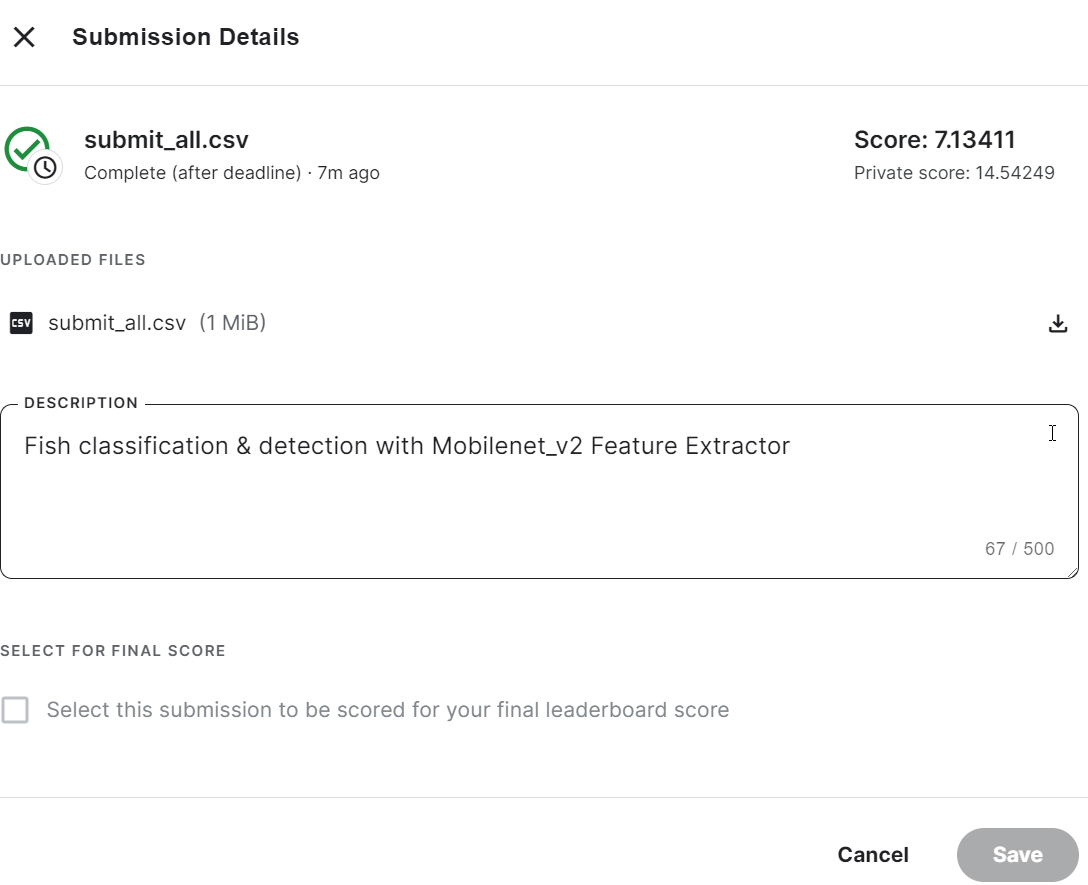